# Cybersecurity Analysis with Community Detection

In this notebook, we'll apply our community detection methods to cybersecurity data from the UNSW-NB15 dataset. We'll:

1. Process the UNSW-NB15 dataset and construct a graph
2. Perform feature selection to identify important network attributes
3. Apply various community detection methods
4. Evaluate how well communities align with attack patterns
5. Compare the performance of different methods

In [5]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import rustworkx as rx
import torch
import time
import pickle
import glob
from pathlib import Path
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Import community detection methods
from community_detection.traditional_methods import (
    run_louvain, run_leiden, run_infomap, run_label_propagation, run_spectral_clustering
)
from community_detection.gnn_community_detection import (
    rwx_to_pyg, extract_embeddings, detect_communities_from_embeddings, run_gnn_community_detection
)
from community_detection.overlapping_community_detection import (
    run_bigclam, run_demon, run_slpa, run_gnn_overlapping
)
from community_detection.dynamic_gnn import (
    run_dynamic_community_detection, generate_dynamic_graphs
)
from community_detection.visualization import (
    visualize_communities, plot_overlapping_communities, visualize_embeddings
)
from community_detection.data_prep import (
    compute_graph_statistics, display_graph_statistics
)

# Define paths with proper organization
DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'unsw')
os.makedirs(DATA_DIR, exist_ok=True)

# UNSW Dataset locations
CSV_DIR = os.path.join(DATA_DIR, "CSV Files")
FEATURES_PATH = os.path.join(CSV_DIR, "NUSW-NB15_features.csv")
TRAINING_SET_PATH = os.path.join(CSV_DIR, "Training and Testing Sets", "UNSW_NB15_training-set.csv")
TESTING_SET_PATH = os.path.join(CSV_DIR, "Training and Testing Sets", "UNSW_NB15_testing-set.csv")
DATA_PATHS = glob.glob(os.path.join(CSV_DIR, "UNSW-NB15_*.csv"))

# Sample data paths (fallback)
SAMPLE_DATA_PATH = os.path.join(os.getcwd(), '..', 'data', 'samples', 'unsw_sample.csv')
SAMPLE_FEATURES_PATH = os.path.join(os.getcwd(), '..', 'data', 'samples', 'unsw_features_sample.csv')

# Results and cache paths
RESULTS_DIR = os.path.join(DATA_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)
GRAPH_PATH = os.path.join(RESULTS_DIR, "unsw_graph.pkl")  # Using .pkl instead of .pt
PROC_DIR = os.path.join(RESULTS_DIR, "processed")
os.makedirs(PROC_DIR, exist_ok=True)

# Try to use polars for faster data processing if available
try:
    import polars as pl
    USE_POLARS = True
    print("Using Polars for faster data processing")
except ImportError:
    USE_POLARS = False
    print("Polars not available, using pandas")

Using Polars for faster data processing


## 1. Download and Process the UNSW-NB15 Dataset

The UNSW-NB15 dataset is a comprehensive network traffic dataset that contains normal traffic and attack traffic. It includes 49 features and labels for different attack types.

Note: You'll need to manually download the dataset from https://research.unsw.edu.au/projects/unsw-nb15-dataset and place the CSV files in the data/unsw directory.

In [6]:
def load_dataset(use_cache=True):
    """
    Load the UNSW-NB15 dataset and features information
    Optimized with Polars lazy evaluation and streaming for memory efficiency
    
    Parameters:
    -----------
    use_cache: bool
        Whether to use cached processed data if available
    
    Returns:
    --------
    data: polars.DataFrame or pandas.DataFrame
        Combined dataset
    features_info: polars.DataFrame or pandas.DataFrame
        Feature information
    """
    # Check for cached data
    cache_path = os.path.join(PROC_DIR, "unsw_processed_data.pkl")
    if use_cache and os.path.exists(cache_path):
        print(f"Loading processed data from cache: {cache_path}")
        with open(cache_path, 'rb') as f:
            cache_data = pickle.load(f)
            record_count = cache_data['data'].height if USE_POLARS else len(cache_data['data'])
            print(f"Loaded {record_count} records from cache")
            return cache_data['data'], cache_data['features_info']
    
    print("Loading UNSW-NB15 dataset...")
    
    # 1. Try to load features information with UTF-8 handling
    print(f"Loading feature information from {FEATURES_PATH}")
    features_info = None
    
    # Create a function to safely load CSV with encoding fallbacks
    def safe_read_csv(path, use_polars=USE_POLARS):
        """Safely load CSV with multiple encoding attempts"""
        encodings = ['utf-8', 'latin-1', 'cp1252', 'ISO-8859-1']
        encoding_options = {'encoding': 'utf8-lossy'} if use_polars else {}
        
        for encoding in encodings:
            try:
                if use_polars:
                    # For polars, use lazy loading and utf8-lossy for robust handling
                    return pl.scan_csv(path, ignore_errors=True, **encoding_options).collect()
                else:
                    # For pandas, try different encodings
                    return pd.read_csv(path, encoding=encoding, on_bad_lines='skip')
            except Exception as e:
                print(f"  Failed with {encoding}: {str(e)}")
                continue
        return None

    # Try to load features information with encoding fallback
    try:
        features_info = safe_read_csv(FEATURES_PATH)
        if features_info is not None:
            print(f"Loaded {features_info.height if USE_POLARS else len(features_info)} features")
        else:
            raise FileNotFoundError("Could not read features file with any encoding")
    except Exception as e:
        print(f"Features file error at {FEATURES_PATH}: {e}")
        print(f"Trying alternative features path: {SAMPLE_FEATURES_PATH}")
        try:
            features_info = safe_read_csv(SAMPLE_FEATURES_PATH)
            if features_info is not None:
                print(f"Loaded {features_info.height if USE_POLARS else len(features_info)} sample features")
            else:
                raise FileNotFoundError("Could not read sample features file with any encoding")
        except Exception as e:
            print(f"No features information found: {e}. Will proceed without feature descriptions.")
            features_info = None
    
    # 2. Check if any CSV data files exist
    if DATA_PATHS:
        # Filter out non-data files
        data_files = [p for p in DATA_PATHS if os.path.basename(p).startswith("UNSW-NB15_") and 
                     not "features" in p.lower() and not "list" in p.lower()]
        print(f"Found {len(data_files)} UNSW data files")
    else:
        data_files = []
        print("No UNSW data files found in CSV Files directory.")
    
    # 3. Check for training/testing sets
    train_test_files = []
    if os.path.exists(TRAINING_SET_PATH):
        train_test_files.append(TRAINING_SET_PATH)
        print(f"Found training set: {TRAINING_SET_PATH}")
    
    if os.path.exists(TESTING_SET_PATH):
        train_test_files.append(TESTING_SET_PATH)
        print(f"Found testing set: {TESTING_SET_PATH}")
    
    # 4. Check for PCAP and Argus files - added for full dataset support
    pcap_files = glob.glob(os.path.join(DATA_DIR, "pcap files/**/*.pcap"), recursive=True)
    argus_files = glob.glob(os.path.join(DATA_DIR, "Argus Files/**/*.argus"), recursive=True)
    
    if pcap_files:
        print(f"Found {len(pcap_files)} PCAP files")
    
    if argus_files:
        print(f"Found {len(argus_files)} Argus files")
    
    # 5. Check for BRO files
    bro_dirs = glob.glob(os.path.join(DATA_DIR, "BRO Files/**/*"), recursive=True)
    bro_dirs = [d for d in bro_dirs if os.path.isdir(d)]
    
    if bro_dirs:
        print(f"Found {len(bro_dirs)} BRO directories")
        
        # Look for specific BRO log files
        bro_conn_files = glob.glob(os.path.join(DATA_DIR, "BRO Files/**/conn*.log"), recursive=True)
        bro_dns_files = glob.glob(os.path.join(DATA_DIR, "BRO Files/**/dns*.log"), recursive=True)
        bro_http_files = glob.glob(os.path.join(DATA_DIR, "BRO Files/**/http*.log"), recursive=True)
        
        if bro_conn_files:
            print(f"  Found {len(bro_conn_files)} BRO connection logs")
        if bro_dns_files:
            print(f"  Found {len(bro_dns_files)} BRO DNS logs")
        if bro_http_files:
            print(f"  Found {len(bro_http_files)} BRO HTTP logs")
    
    # 6. Load data from available sources - optimized for streaming with polars
    combined_data = None
    all_schemas = {}  # Track schemas for each file
    
    # Function to progressively build the combined dataset
    def add_data_to_combined(new_df, combined=None):
        if combined is None:
            return new_df
        
        # For new implementation, we'll collect all data first and then combine
        if combined_data_list is not None:
            combined_data_list.append(new_df)
            return combined
        
        # Old implementation
        if USE_POLARS:
            # Ensure schemas match
            if combined.width != new_df.width:
                print(f"  Warning: Schema mismatch. Current width: {combined.width}, New width: {new_df.width}")
                # Find common columns
                common_cols = list(set(combined.columns).intersection(set(new_df.columns)))
                if common_cols:
                    print(f"  Using {len(common_cols)} common columns for append")
                    # Select only common columns
                    combined_subset = combined.select(common_cols)
                    new_df_subset = new_df.select(common_cols)
                    return pl.concat([combined_subset, new_df_subset])
                else:
                    print("  No common columns found, not appending")
                    return combined
            return pl.concat([combined, new_df])
        else:
            # For pandas, handle differing columns
            if set(combined.columns) != set(new_df.columns):
                # Find common columns
                common_cols = list(set(combined.columns).intersection(set(new_df.columns)))
                if common_cols:
                    # Select only common columns
                    combined_subset = combined[common_cols]
                    new_df_subset = new_df[common_cols]
                    return pd.concat([combined_subset, new_df_subset], ignore_index=True)
                else:
                    return combined
            return pd.concat([combined, new_df], ignore_index=True)
    
    # New approach: collect all dataframes first, then find common columns
    combined_data_list = []
    schemas = {}
    
    # First try the main CSV files (usually larger and more complete)
    if data_files:
        total_records = 0
        for path in data_files:
            print(f"Loading {os.path.basename(path)}...")
            try:
                # For polars, use streaming with lazy evaluation
                if USE_POLARS:
                    # Create scanning reader with optimized settings for large files
                    df_lazy = pl.scan_csv(
                        path, 
                        ignore_errors=True,
                        encoding='utf8-lossy',
                        rechunk=False,
                        low_memory=True
                    )
                    
                    df = df_lazy.collect()
                    record_count = df.height
                    schemas[path] = set(df.columns)
                else:
                    # For pandas, use chunk reading for large files
                    chunk_size = 100000
                    chunks = []
                    for chunk in pd.read_csv(path, chunksize=chunk_size, on_bad_lines='skip', encoding='latin-1'):
                        chunks.append(chunk)
                    df = pd.concat(chunks, ignore_index=True)
                    record_count = len(df)
                    schemas[path] = set(df.columns)
                
                print(f"  Loaded {record_count} records")
                total_records += record_count
                
                # Add to our collection
                combined_data_list.append(df)
                
            except Exception as e:
                print(f"  Error loading {path}: {str(e)}")
    
    # Also add training/testing sets
    if train_test_files:
        for path in train_test_files:
            print(f"Loading {os.path.basename(path)}...")
            try:
                if USE_POLARS:
                    df = pl.scan_csv(path, ignore_errors=True, encoding='utf8-lossy').collect()
                    record_count = df.height
                    schemas[path] = set(df.columns)
                else:
                    df = pd.read_csv(path, on_bad_lines='skip', encoding='latin-1')
                    record_count = len(df)
                    schemas[path] = set(df.columns)
                
                print(f"  Loaded {record_count} records")
                
                # Add to our collection
                combined_data_list.append(df)
                
            except Exception as e:
                print(f"  Error loading {path}: {str(e)}")
    
    # Process Argus files if available and needed
    if (len(combined_data_list) == 0 or sum(len(df) if not USE_POLARS else df.height for df in combined_data_list) < 10000) and argus_files:
        print("Processing Argus files to extract network traffic...")
        
        # Find any existing Argus CSV conversions
        argus_csv_files = glob.glob(os.path.join(DATA_DIR, "Argus Files/**/CSV of Argus/*.csv"), recursive=True)
        
        if argus_csv_files:
            print(f"Found {len(argus_csv_files)} pre-converted Argus CSV files")
            for path in argus_csv_files[:10]:  # Limit to first 10 to avoid memory issues
                try:
                    print(f"Loading {os.path.basename(path)}...")
                    if USE_POLARS:
                        df = pl.scan_csv(path, ignore_errors=True, encoding='utf8-lossy').collect()
                        record_count = df.height
                        schemas[path] = set(df.columns)
                    else:
                        df = pd.read_csv(path, on_bad_lines='skip', encoding='latin-1')
                        record_count = len(df)
                        schemas[path] = set(df.columns)
                    
                    print(f"  Loaded {record_count} records")
                    
                    # Handle column renaming for consistency
                    col_mapping = {
                        'src': 'srcip',
                        'dst': 'dstip',
                        'source': 'srcip',
                        'destination': 'dstip',
                        'sip': 'srcip',
                        'dip': 'dstip',
                        'src ip': 'srcip',
                        'dst ip': 'dstip',
                        'source ip': 'srcip',
                        'destination ip': 'dstip'
                    }
                    
                    # Rename columns for consistency
                    if USE_POLARS:
                        for old_col, new_col in col_mapping.items():
                            if old_col in df.columns and new_col not in df.columns:
                                df = df.rename({old_col: new_col})
                    else:
                        for old_col, new_col in col_mapping.items():
                            if old_col in df.columns and new_col not in df.columns:
                                df.rename(columns={old_col: new_col}, inplace=True)
                    
                    # Add to our collection
                    combined_data_list.append(df)
                    
                except Exception as e:
                    print(f"  Error loading {path}: {str(e)}")
    
    # Process BRO files if available and needed
    if (len(combined_data_list) == 0 or sum(len(df) if not USE_POLARS else df.height for df in combined_data_list) < 10000) and (bro_conn_files or bro_dns_files):
        
        print("Processing BRO log files...")
        
        # Process BRO conn logs first (they contain most network connections)
        for path in bro_conn_files[:5]:  # Limit to first 5 to avoid memory issues
            try:
                print(f"Parsing BRO connection log: {os.path.basename(path)}...")
                
                # BRO logs have a custom format, often tab-separated with # comments
                with open(path, 'r', encoding='latin-1') as f:
                    lines = f.readlines()
                
                # Extract header (first non-comment line)
                header = None
                data_lines = []
                for line in lines:
                    if line.startswith('#fields'):
                        header = line.strip().replace('#fields', '').strip().split('\t')
                    elif not line.startswith('#'):
                        data_lines.append(line.strip().split('\t'))
                
                if header and data_lines:
                    # Create DataFrame from parsed data
                    if USE_POLARS:
                        bro_df = pl.DataFrame({
                            header[i]: [line[i] if i < len(line) else None for line in data_lines]
                            for i in range(len(header))
                        })
                    else:
                        bro_df = pd.DataFrame(data_lines, columns=header)
                    
                    print(f"  Parsed {len(data_lines)} records")
                    
                    # Map BRO fields to expected schema
                    field_mapping = {
                        'id.orig_h': 'srcip',
                        'id.resp_h': 'dstip',
                        'id.orig_p': 'sport',
                        'id.resp_p': 'dsport',
                        'proto': 'proto',
                        'service': 'service',
                        'duration': 'dur',
                        'orig_bytes': 'sbytes',
                        'resp_bytes': 'dbytes',
                        'conn_state': 'state'
                    }
                    
                    # Rename columns according to mapping
                    if USE_POLARS:
                        for bro_field, std_field in field_mapping.items():
                            if bro_field in bro_df.columns:
                                bro_df = bro_df.rename({bro_field: std_field})
                        # Add label column (assume normal traffic)
                        bro_df = bro_df.with_column(pl.lit(0).alias('label'))
                    else:
                        for bro_field, std_field in field_mapping.items():
                            if bro_field in bro_df.columns:
                                bro_df.rename(columns={bro_field: std_field}, inplace=True)
                        # Add label column (assume normal traffic)
                        bro_df['label'] = 0
                    
                    schemas[path] = set(bro_df.columns)
                    combined_data_list.append(bro_df)
                else:
                    print("  Could not parse BRO log format")
            except Exception as e:
                print(f"  Error processing BRO log {path}: {str(e)}")
    
    # Now that we have all dataframes, find common columns and merge
    if combined_data_list:
        # Find columns that appear in all dataframes
        if USE_POLARS:
            all_cols = set.intersection(*[set(df.columns) for df in combined_data_list])
        else:
            all_cols = set.intersection(*[set(df.columns) for df in combined_data_list])
        
        if len(all_cols) == 0:
            # If no common columns, try to find the most useful set of columns
            # This happens if file schemas differ greatly
            preferred_cols = ['srcip', 'dstip', 'sport', 'dsport', 'proto', 'label', 'attack_cat']
            for col in preferred_cols:
                df_with_col = [df for df in combined_data_list if col in df.columns]
                if len(df_with_col) >= 2:  # At least 2 dataframes have this column
                    all_cols.add(col)
            
            # Add some useful data columns if possible
            for col in combined_data_list[0].columns:
                if 'bytes' in col.lower() or 'pkts' in col.lower() or 'time' in col.lower():
                    df_with_col = [df for df in combined_data_list if col in df.columns]
                    if len(df_with_col) >= 1:
                        all_cols.add(col)
        
        # If still no common columns, just use the first dataframe
        if len(all_cols) == 0:
            print("Warning: No common columns found across files. Using first dataframe as base.")
            combined_data = combined_data_list[0]
        else:
            print(f"Found {len(all_cols)} common columns across datasets: {', '.join(sorted(all_cols))}")
            
            # Ensure that essential columns are included
            essential_cols = ['srcip', 'dstip', 'label']
            for col in essential_cols:
                if col not in all_cols:
                    print(f"WARNING: Essential column '{col}' not in common columns!")
            
            # Extract selected columns and combine
            if USE_POLARS:
                # Use polars concat with only common columns
                dfs_to_concat = [df.select([col for col in all_cols if col in df.columns]) for df in combined_data_list]
                combined_data = pl.concat(dfs_to_concat)
            else:
                # Use pandas concat with only common columns
                dfs_to_concat = [df[[col for col in all_cols if col in df.columns]] for df in combined_data_list]
                combined_data = pd.concat(dfs_to_concat, ignore_index=True)
        
        record_count = combined_data.height if USE_POLARS else len(combined_data)
        print(f"Combined dataset has {record_count} records")
        
        # Optimize memory usage for large datasets
        if USE_POLARS and record_count > 1000000:
            print("Optimizing memory usage for large dataset...")
            # Perform type optimization
            for col in combined_data.columns:
                # Skip non-numeric columns
                if combined_data[col].dtype in [pl.Utf8, pl.Categorical, pl.Object]:
                    continue
                
                try:
                    if combined_data[col].dtype == pl.Float64:
                        # Downcast floats to Float32
                        combined_data = combined_data.with_column(
                            pl.col(col).cast(pl.Float32)
                        )
                    elif combined_data[col].dtype == pl.Int64:
                        # Try to downcast integers if possible
                        min_val = combined_data[col].min()
                        max_val = combined_data[col].max()
                        if min_val >= 0 and max_val < 256:
                            combined_data = combined_data.with_column(
                                pl.col(col).cast(pl.UInt8)
                            )
                        elif min_val >= 0 and max_val < 65536:
                            combined_data = combined_data.with_column(
                                pl.col(col).cast(pl.UInt16)
                            )
                except Exception as e:
                    print(f"  Error optimizing column {col}: {e}")
    else:
        # Fall back to sample data if no files were loaded
        print("No UNSW-NB15 data files could be loaded.")
        
        # Try loading sample data if available
        if os.path.exists(SAMPLE_DATA_PATH):
            print(f"Loading sample data from {SAMPLE_DATA_PATH}")
            try:
                if USE_POLARS:
                    sample_data = pl.scan_csv(SAMPLE_DATA_PATH, ignore_errors=True).collect()
                    print(f"Loaded {sample_data.height} records from sample data")
                else:
                    sample_data = pd.read_csv(SAMPLE_DATA_PATH, on_bad_lines='skip')
                    print(f"Loaded {len(sample_data)} records from sample data")
                
                # If we don't have features info, use the sample features
                if features_info is None and os.path.exists(SAMPLE_FEATURES_PATH):
                    if USE_POLARS:
                        features_info = pl.scan_csv(SAMPLE_FEATURES_PATH, ignore_errors=True).collect()
                    else:
                        features_info = pd.read_csv(SAMPLE_FEATURES_PATH, on_bad_lines='skip')
                    print(f"Loaded feature information from sample data")
                
                # Use sample as the combined dataset
                combined_data = sample_data
                print("Using sample data for analysis")
                
                # Cache the processed data
                if use_cache:
                    with open(cache_path, 'wb') as f:
                        pickle.dump({'data': combined_data, 'features_info': features_info}, f)
                    print(f"Cached processed data to {cache_path}")
                
                return combined_data, features_info
                
            except Exception as e:
                print(f"Error loading sample data: {e}")
        
        # If nothing works, create synthetic data
        print("Creating synthetic data for demonstration purposes...")
        
        # Create synthetic data with similar structure to UNSW-NB15
        import torch
        
        # Use torch instead of numpy for tensor operations
        torch.manual_seed(42)
        n_samples = 1000
        n_features = 10
        
        # Generate synthetic features with PyTorch
        X = torch.rand(n_samples, n_features).numpy()
        
        # Generate synthetic source and destination IPs
        src_ips = [f"192.168.1.{torch.randint(1, 255, (1,)).item()}" for _ in range(n_samples)]
        dst_ips = [f"10.0.0.{torch.randint(1, 255, (1,)).item()}" for _ in range(n_samples)]
        
        # Generate synthetic labels (20% attacks)
        labels = torch.bernoulli(torch.full((n_samples,), 0.2)).int().numpy()
        
        # Create feature names
        feature_names = [f"feature_{i}" for i in range(n_features)]
        
        attack_types = ['exploit', 'dos', 'reconnaissance', 'brute-force']
        
        # Create DataFrame
        if USE_POLARS:
            # Use Polars native API for creating dataframe
            data_dict = {}
            for i in range(n_features):
                data_dict[feature_names[i]] = X[:, i]
            
            data_dict['srcip'] = src_ips
            data_dict['dstip'] = dst_ips
            data_dict['label'] = labels
            
            # Generate attack categories
            attack_cats = []
            for l in labels:
                if l == 0:
                    attack_cats.append('normal')
                else:
                    attack_cats.append(attack_types[torch.randint(0, len(attack_types), (1,)).item()])
            
            data_dict['attack_cat'] = attack_cats
            combined_data = pl.DataFrame(data_dict)
            
            # Create correlation between features and labels
            for i in range(3):
                combined_data = combined_data.with_column(
                    pl.when(pl.col('label') == 1)
                    .then(pl.col(feature_names[i]) + 0.3)
                    .otherwise(pl.col(feature_names[i]))
                    .alias(feature_names[i])
                )
        else:
            # Fallback to pandas if needed
            combined_data = pd.DataFrame(X, columns=feature_names)
            combined_data['srcip'] = src_ips
            combined_data['dstip'] = dst_ips
            combined_data['label'] = labels
            
            # Generate attack categories
            attack_cats = []
            for l in labels:
                if l == 0:
                    attack_cats.append('normal')
                else:
                    idx = torch.randint(0, len(attack_types), (1,)).item()
                    attack_cats.append(attack_types[idx])
            
            combined_data['attack_cat'] = attack_cats
            
            # Create correlation between features and labels
            for i in range(3):
                combined_data.loc[combined_data['label'] == 1, feature_names[i]] += 0.3
        
        print(f"Created synthetic dataset with {combined_data.height if USE_POLARS else len(combined_data)} records")
    
    # Cache the processed data
    if use_cache and combined_data is not None:
        with open(cache_path, 'wb') as f:
            pickle.dump({'data': combined_data, 'features_info': features_info}, f)
        print(f"Cached processed data to {cache_path}")
    
    return combined_data, features_info

# Load the dataset
print("Loading UNSW-NB15 dataset...")
data, features_info = load_dataset(use_cache=True)

# Display dataset summary
if data is not None:
    print("\nDataset preview:")
    if USE_POLARS:
        display(data.head(5))
    else:
        display(data.head())
    
    # Display feature info if available
    if features_info is not None:
        print("\nFeature information preview:")
        if USE_POLARS:
            display(features_info.head(5))
        else:
            display(features_info.head())
    
    # Display class distribution
    if 'label' in data.columns:
        if USE_POLARS:
            label_counts = data.group_by('label').agg(pl.count()).sort('label')
            normal_count = label_counts.filter(pl.col('label') == 0)['count'].item() if label_counts.filter(pl.col('label') == 0).height > 0 else 0
            attack_count = label_counts.filter(pl.col('label') == 1)['count'].item() if label_counts.filter(pl.col('label') == 1).height > 0 else 0
            total = normal_count + attack_count
        else:
            normal_count = len(data[data['label'] == 0])
            attack_count = len(data[data['label'] == 1])
            total = len(data)
        
        print(f"\nClass distribution:")
        print(f"- Normal: {normal_count} ({normal_count/total*100:.1f}%)")
        print(f"- Attack: {attack_count} ({attack_count/total*100:.1f}%)")
        
        # Plot class distribution
        plt.figure(figsize=(8, 6))
        if USE_POLARS:
            counts = data.group_by('label').agg(pl.count()).sort('label')
            plt.bar(counts['label'].to_list(), counts['count'].to_list())
        else:
            sns.countplot(x='label', data=data)
        plt.title('Class Distribution')
        plt.xlabel('Label (0=Normal, 1=Attack)')
        plt.ylabel('Count')
        plt.xticks([0, 1], ['Normal', 'Attack'])
        plt.show()
        
        # Plot attack categories if available
        if 'attack_cat' in data.columns:
            plt.figure(figsize=(10, 6))
            if USE_POLARS:
                attack_data = data.filter(pl.col('label') == 1)
                attack_counts = attack_data.group_by('attack_cat').agg(pl.count()).sort('count', descending=True)
                attack_cats = attack_counts['attack_cat'].to_list()
                counts = attack_counts['count'].to_list()
                plt.barh(attack_cats, counts)
            else:
                attack_data = data[data['label'] == 1]
                sns.countplot(y='attack_cat', data=attack_data, order=attack_data['attack_cat'].value_counts().index)
            plt.title('Attack Categories')
            plt.ylabel('Attack Category')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()

Loading UNSW-NB15 dataset...
Loading processed data from cache: /home/braden/gnn-cd/notebooks/../data/unsw/results/processed/unsw_processed_data.pkl
Loaded 700000 records from cache

Dataset preview:


59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0_duplicated_0,dns,500473.9375,621800.9375,2,2_duplicated_0,0_duplicated_1,0_duplicated_2,0_duplicated_3,0_duplicated_4,66,82,0_duplicated_5,0_duplicated_6,0_duplicated_7,0_duplicated_8,1421927414,1421927414_duplicated_0,0.017,0.013,0_duplicated_9,0_duplicated_10,0_duplicated_11,0_duplicated_12,0_duplicated_13,0_duplicated_14,0_duplicated_15,0_duplicated_16,3,7,1,3_duplicated_0,1_duplicated_0,1_duplicated_1,1_duplicated_2,,0_duplicated_17
str,i64,str,i64,str,str,f64,i64,i64,i64,i64,i64,i64,str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64
"""59.166.0.0""",33661,"""149.171.126.9""",1024,"""udp""","""CON""",0.036133,528,304,31,29,0,0,"""-""",87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,null,0
"""59.166.0.6""",1464,"""149.171.126.7""",53,"""udp""","""CON""",0.001119,146,178,31,29,0,0,"""dns""",521894.5313,636282.375,2,2,0,0,0,0,73,89,0,0,0.0,0.0,1421927414,1421927414,0.017,0.013,0.0,0.0,0.0,0,0,0,0,0,12,8,1,2,2,1,1,null,0
"""59.166.0.5""",3593,"""149.171.126.5""",53,"""udp""","""CON""",0.001209,132,164,31,29,0,0,"""dns""",436724.5625,542597.1875,2,2,0,0,0,0,66,82,0,0,0.0,0.0,1421927414,1421927414,0.043,0.014,0.0,0.0,0.0,0,0,0,0,0,6,9,1,1,1,1,1,null,0
"""59.166.0.3""",49664,"""149.171.126.0""",53,"""udp""","""CON""",0.001169,146,178,31,29,0,0,"""dns""",499572.25,609067.5625,2,2,0,0,0,0,73,89,0,0,0.0,0.0,1421927414,1421927414,0.005,0.003,0.0,0.0,0.0,0,0,0,0,0,7,9,1,1,1,1,1,null,0
"""59.166.0.0""",32119,"""149.171.126.9""",111,"""udp""","""CON""",0.078339,568,312,31,29,0,0,"""-""",43503.23438,23896.14258,4,4,0,0,0,0,142,78,0,0,29.682221,34.37034,1421927414,1421927414,21.003,24.315,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,null,0



Feature information preview:


No.,Name,Type,Description
i64,str,str,str
1,"""srcip""","""nominal""","""Source IP address"""
2,"""sport""","""integer""","""Source port number"""
3,"""dstip""","""nominal""","""Destination IP address"""
4,"""dsport""","""integer""","""Destination port number"""
5,"""proto""","""nominal""","""Transaction protocol"""


## 2. Feature Selection and Analysis

Let's perform feature selection to identify the most important features for attack detection.

Performing feature selection to identify network attributes associated with attacks...

Checking for missing values...
Found 677856 missing values. Imputing with column means...
Numeric columns: 43
Categorical columns: 6
Converting categorical columns: 59.166.0.0, 149.171.126.6, udp, CON, dns, 
Categorical columns: 6
Converting categorical columns: 59.166.0.0, 149.171.126.6, udp, CON, dns, 


Feature selection criteria: F-statistic (ANOVA F-value between features and target)
This selects features with the strongest relationship to the target variable (attack/normal)

Selected 15 features:
- 1390: NaN or Inf score
- 53: NaN or Inf score
- 0.001055: NaN or Inf score
- 132: NaN or Inf score
- 164: NaN or Inf score
- 31: NaN or Inf score
- 29: NaN or Inf score
- 0: NaN or Inf score
- 0_duplicated_0: NaN or Inf score
- 500473.9375: NaN or Inf score
- 621800.9375: NaN or Inf score
- 2: NaN or Inf score
- 2_duplicated_0: NaN or Inf score
- 0_duplicated_1: NaN or Inf score
- 0_duplicated_2: Na

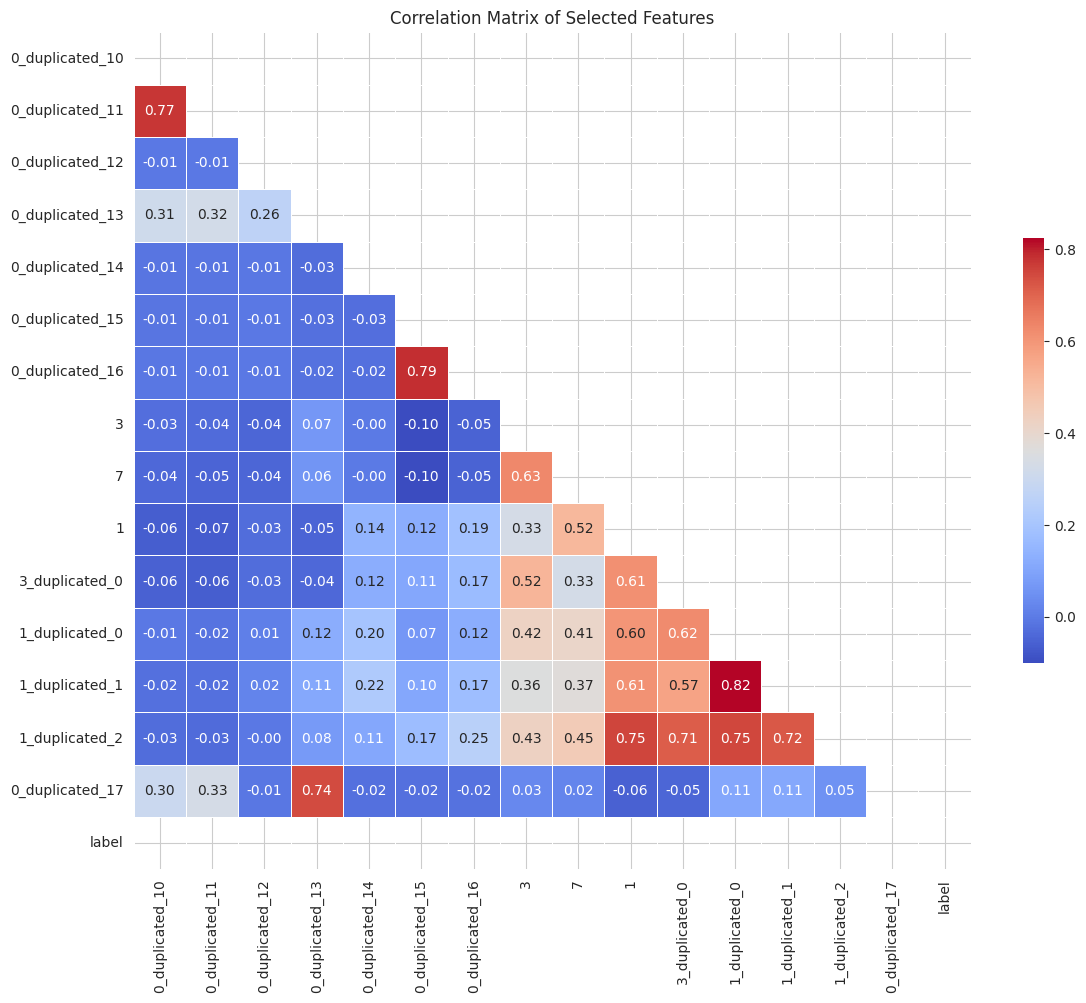

In [7]:
def feature_selection(data, k=20):
    """
    Perform feature selection on the dataset
    
    Parameters:
    -----------
    data: pandas.DataFrame or polars.DataFrame
        Dataset with features and labels
    k: int
        Number of features to select
        
    Returns:
    --------
    selected_features: list
        List of selected feature names
    X_selected: numpy.ndarray
        Feature matrix with selected features
    y: numpy.ndarray
        Labels array
    """
    # Separate features and labels
    exclude_cols = ['label', 'attack_cat', 'srcip', 'dstip', 'sport', 'dsport']
    
    # Handle Polars DataFrames differently than pandas
    if USE_POLARS:
        # Convert to pandas for sklearn compatibility
        # First filter out exclude columns that exist
        feature_columns = [col for col in data.columns if col not in exclude_cols]
        # Convert to pandas
        X_df = data.select(feature_columns).to_pandas()
        
        # Get labels
        if 'label' in data.columns:
            y = data.select('label').to_numpy().flatten()
        else:
            y = np.zeros(data.height)
    else:
        # Pandas version - drop excluded columns that exist
        X_df = data.drop([col for col in exclude_cols if col in data.columns], axis=1)
        # Get labels
        y = data['label'].values if 'label' in data.columns else np.zeros(len(data))
    
    # Check for and handle missing values
    print("Checking for missing values...")
    missing_values = X_df.isna().sum().sum()
    if missing_values > 0:
        print(f"Found {missing_values} missing values. Imputing with column means...")
        # For each column, fill NaN values with the mean of that column
        for col in X_df.columns:
            if X_df[col].isna().any():
                # For numeric columns, use mean
                if np.issubdtype(X_df[col].dtype, np.number):
                    col_mean = X_df[col].mean()
                    X_df[col].fillna(col_mean, inplace=True)
                else:
                    # For categorical columns, use most frequent value
                    most_frequent = X_df[col].mode()[0] if not X_df[col].mode().empty else "unknown"
                    X_df[col].fillna(most_frequent, inplace=True)
    
    # Handle non-numeric columns
    numeric_cols = X_df.select_dtypes(include=['number']).columns
    categorical_cols = X_df.select_dtypes(exclude=['number']).columns
    
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")
    
    # Handle categorical features with one-hot encoding
    if len(categorical_cols) > 0:
        print(f"Converting categorical columns: {', '.join(categorical_cols[:10])}{'...' if len(categorical_cols) > 10 else ''}")
        try:
            X_df = pd.get_dummies(X_df, columns=categorical_cols, drop_first=True)
        except Exception as e:
            print(f"Error during one-hot encoding: {e}")
            print("Trying alternative approach for categorical columns...")
            # Alternative approach: encode each column separately
            for col in categorical_cols:
                try:
                    # Convert column to string first to ensure it works
                    X_df[col] = X_df[col].astype(str)
                    # Create dummies for this column
                    dummies = pd.get_dummies(X_df[col], prefix=col, drop_first=True)
                    # Join with original dataframe
                    X_df = pd.concat([X_df.drop(columns=[col]), dummies], axis=1)
                except Exception as e2:
                    print(f"Could not encode column {col}: {e2}")
                    # Drop problematic column
                    X_df = X_df.drop(columns=[col])
    
    # Ensure we have enough features before selection
    if len(X_df.columns) < k:
        print(f"Warning: Only {len(X_df.columns)} features available, which is less than k={k}")
        k = min(k, len(X_df.columns))
    
    # Remove any remaining columns with NaN values
    cols_with_nan = X_df.columns[X_df.isna().any()].tolist()
    if cols_with_nan:
        print(f"Removing {len(cols_with_nan)} columns that still have NaNs after imputation")
        X_df = X_df.drop(columns=cols_with_nan)
    
    # Remove constant columns (variance = 0)
    const_cols = [col for col in X_df.columns if X_df[col].nunique() <= 1]
    if const_cols:
        print(f"Removing {len(const_cols)} constant columns")
        X_df = X_df.drop(columns=const_cols)
    
    # Ensure we only have numeric data - check for any non-numeric columns
    non_numeric_cols = X_df.select_dtypes(exclude=['number']).columns.tolist()
    if non_numeric_cols:
        print(f"Warning: Found {len(non_numeric_cols)} non-numeric columns after processing. Removing them.")
        X_df = X_df.drop(columns=non_numeric_cols)
    
    # Convert to numpy arrays
    X = X_df.values
    
    # Now X should be numeric only, check for infinite values
    try:
        has_inf = np.any(~np.isfinite(X))
        if has_inf:
            print("Warning: Found infinite values. Replacing with large values...")
            X = np.nan_to_num(X, nan=0, posinf=1e10, neginf=-1e10)
    except TypeError:
        print("Warning: Could not check for infinite values. Applying nan_to_num anyway...")
        X = np.nan_to_num(X, nan=0, posinf=1e10, neginf=-1e10)
    
    # Standardize numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Double check there are no NaNs or infs in the scaled data
    try:
        if np.any(~np.isfinite(X_scaled)):
            print("Warning: Found NaN or infinite values after scaling. Replacing with zeros...")
            X_scaled = np.nan_to_num(X_scaled, nan=0, posinf=0, neginf=0)
    except:
        print("Warning: Could not check for NaN/inf after scaling. Applying nan_to_num anyway...")
        X_scaled = np.nan_to_num(X_scaled, nan=0, posinf=0, neginf=0)
    
    # Explain feature selection criteria
    print(f"\nFeature selection criteria: F-statistic (ANOVA F-value between features and target)")
    print(f"This selects features with the strongest relationship to the target variable (attack/normal)")
    
    # Apply feature selection
    selector = SelectKBest(f_classif, k=k)
    try:
        X_selected = selector.fit_transform(X_scaled, y)
    except ValueError as e:
        print(f"Error during feature selection: {e}")
        print("Attempting to clean data further and retry...")
        
        # Apply more aggressive cleaning
        # Replace any problematic values with zeros
        X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Try again with cleaned data
        X_selected = selector.fit_transform(X_scaled, y)
    
    # Get selected feature names
    selected_features = X_df.columns[selector.get_support()].tolist()
    print(f"\nSelected {len(selected_features)} features:")
    
    # Get feature scores and sort
    scores = selector.scores_
    feature_scores = list(zip(X_df.columns, scores))
    feature_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Display selected features with scores
    for feature, score in feature_scores[:k]:
        if np.isfinite(score):  # Only print if score is finite
            print(f"- {feature}: {score:.2f}")
        else:
            print(f"- {feature}: NaN or Inf score")
    
    # Visualize feature importance scores
    valid_scores = [(f[0], f[1]) for f in feature_scores[:k] if np.isfinite(f[1])]
    if valid_scores:
        plt.figure(figsize=(12, 8))
        plt.barh([f[0] for f in valid_scores], [f[1] for f in valid_scores])
        plt.xlabel('F-Score')
        plt.ylabel('Feature')
        plt.title(f'Top {len(valid_scores)} Features for Attack Detection')
        plt.tight_layout()
        plt.show()
    
    # Create correlation matrix for selected features
    selected_df = pd.DataFrame(X_selected, columns=selected_features)
    selected_df['label'] = y
    
    # Only use correlations if there are enough samples and no issues
    if len(selected_df) > 10 and not selected_df.isna().any().any():
        plt.figure(figsize=(12, 10))
        corr_matrix = selected_df.corr()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.title('Correlation Matrix of Selected Features')
        plt.tight_layout()
        plt.show()
    
    return selected_features, X_selected, y

# Perform feature selection
if data is not None:
    print("Performing feature selection to identify network attributes associated with attacks...\n")
    try:
        selected_features, X_selected, y = feature_selection(data, k=15)
        
        # Calculate and display statistics on selected features
        if 'label' in data.columns:
            # Create a DataFrame with selected features for analysis
            try:
                if USE_POLARS:
                    # For polars, we need to manually create this dataframe
                    features_data = {}
                    for i, feature in enumerate(selected_features):
                        if feature in data.columns:
                            features_data[feature] = data[feature].to_numpy()
                        else:
                            # If feature is a derived column from get_dummies, use the X_selected data
                            features_data[feature] = X_selected[:, i]
                    
                    # Add label column
                    features_data['label'] = data['label'].to_numpy()
                    selected_data = pd.DataFrame(features_data)
                else:
                    # For pandas, we can use the original data
                    selected_data = pd.DataFrame(X_selected, columns=selected_features)
                    selected_data['label'] = y
                
                # Compare feature distributions for normal vs attack traffic
                print("\nFeature distribution comparison (normal vs attack traffic):")
                
                fig, axes = plt.subplots(5, 3, figsize=(15, 18))
                axes = axes.flatten()
                
                for i, feature in enumerate(selected_features[:15]):  # Plot at most 15 features
                    if i < len(axes):
                        sns.boxplot(x='label', y=feature, data=selected_data, ax=axes[i])
                        axes[i].set_title(feature)
                        axes[i].set_xlabel('0=Normal, 1=Attack')
                
                # Remove empty subplots
                for i in range(len(selected_features), len(axes)):
                    fig.delaxes(axes[i])
                    
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error creating feature distribution visualization: {e}")
                print("Skipping feature distribution visualization due to errors.")
    except Exception as e:
        print(f"Feature selection failed: {e}")
        print("Using a subset of numeric columns instead...")
        
        # Fallback approach: just use a subset of numeric columns
        if USE_POLARS:
            numeric_cols = [col for col in data.columns if 
                           col not in ['label', 'attack_cat', 'srcip', 'dstip', 'sport', 'dsport'] and
                           data[col].dtype.is_numeric()]
            
            # Take first 15 numeric columns (or fewer if not enough)
            selected_features = numeric_cols[:min(15, len(numeric_cols))]
            
            # Extract data
            X_selected = data.select(selected_features).to_numpy()
            y = data.select('label').to_numpy().flatten() if 'label' in data.columns else np.zeros(data.height)
        else:
            numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
            numeric_cols = [col for col in numeric_cols if col not in ['label']]
            
            # Take first 15 numeric columns (or fewer if not enough)
            selected_features = numeric_cols[:min(15, len(numeric_cols))]
            
            # Extract data
            X_selected = data[selected_features].values
            y = data['label'].values if 'label' in data.columns else np.zeros(len(data))
        
        print(f"Using {len(selected_features)} numeric features: {', '.join(selected_features[:5])}{'...' if len(selected_features) > 5 else ''}")

## 3. Construct Network Graph

Now we'll construct a graph from the dataset where nodes represent devices (IPs) and edges represent connections.

Loading existing graph from /home/braden/gnn-cd/notebooks/../data/unsw/results/unsw_graph.pkl
Loading graph from /home/braden/gnn-cd/notebooks/../data/unsw/results/unsw_graph.pkl...
Loaded graph with 100000 nodes and 99999 edges in 0.60s
Loaded graph with 100000 nodes and 99999 edges in 0.64s
Visualizing network graph (showing up to 200 nodes out of 100000)...
Graph is too large to visualize completely. Sampling important nodes...
Computing layout (this may take a moment for large graphs)...d graph with 100000 nodes and 99999 edges in 0.64s
Visualizing network graph (showing up to 200 nodes out of 100000)...
Graph is too large to visualize completely. Sampling important nodes...



ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

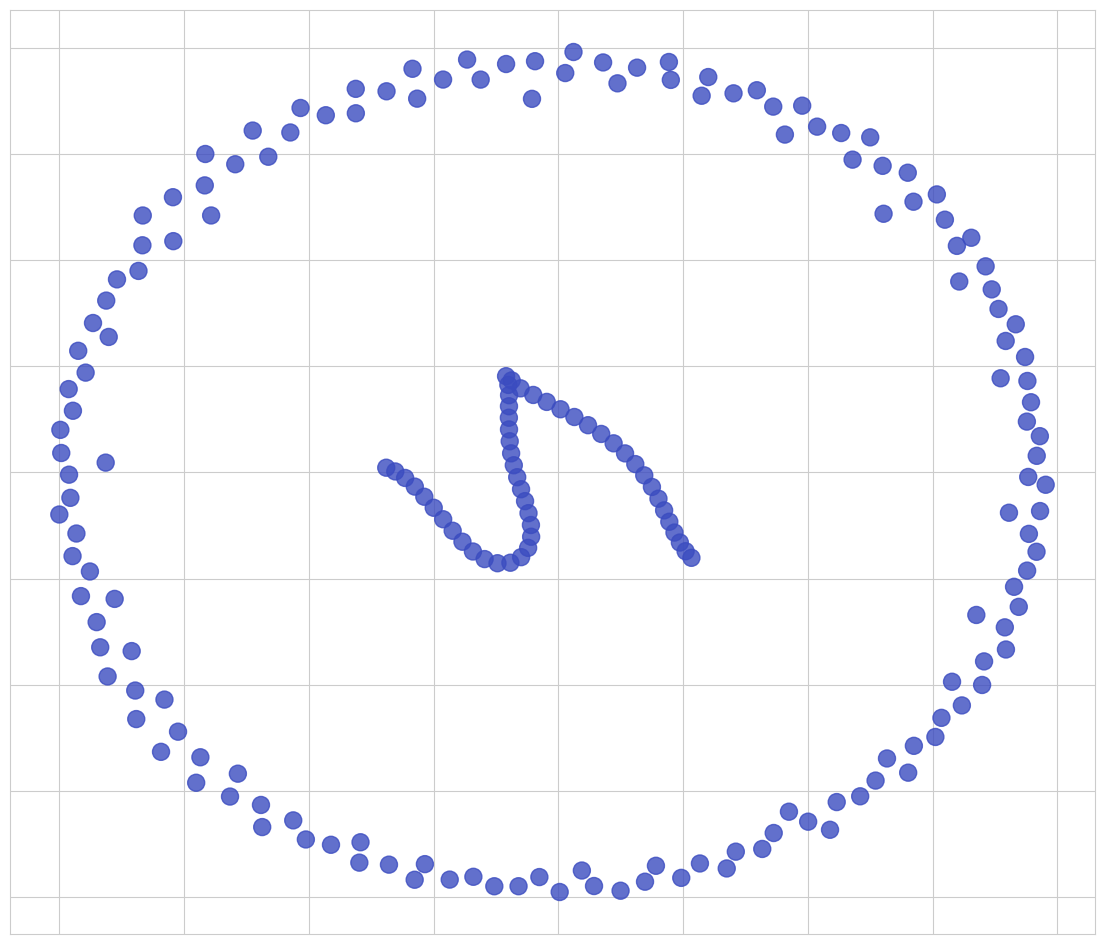

In [8]:
def construct_graph(data, feature_cols, target_col='label', use_cached=True, max_nodes=100000):
    """
    Construct a graph from the dataset where devices are nodes and connections/behavior are edges
    Optimized for large datasets using chunking and efficient processing
    
    Parameters:
    -----------
    data: pandas.DataFrame or polars.DataFrame
        Dataset with features and labels
    feature_cols: list
        List of feature columns to use
    target_col: str
        Target column name
    use_cached: bool
        Whether to use cached graph if available
    max_nodes: int
        Maximum number of nodes to include in the graph (for memory efficiency)
        
    Returns:
    --------
    G: rustworkx.PyGraph
        Constructed graph
    node_mapping: dict
        Mapping from node IDs to device IPs
    """
    # Check if cached graph exists
    if use_cached and os.path.exists(GRAPH_PATH):
        print(f"Loading existing graph from {GRAPH_PATH}")
        start_time = time.time()
        G = load_graph(GRAPH_PATH)
        
        # Create a mapping from node IPs to indices
        node_mapping = {}
        for i in range(len(G)):
            node_data = G.get_node_data(i)
            if 'ip' in node_data:
                node_mapping[node_data['ip']] = i
        
        print(f"Loaded graph with {len(G)} nodes and {G.num_edges()} edges in {time.time() - start_time:.2f}s")
        return G, node_mapping
    
    print("Constructing a network graph where nodes are devices and edges represent communication patterns...")
    start_time = time.time()
    
    # Extract unique source and destination IPs
    if USE_POLARS:
        if 'srcip' in data.columns and 'dstip' in data.columns:
            print("Getting unique IPs... (this may take a moment for large datasets)")
            src_ips = set(data.select('srcip').unique().to_series().to_list())
            dst_ips = set(data.select('dstip').unique().to_series().to_list())
            print(f"Found {len(src_ips)} unique source IPs and {len(dst_ips)} unique destination IPs")
            all_ips = src_ips.union(dst_ips)
        else:
            all_ips = set(range(data.height))
            data = data.with_columns([
                pl.Series(name="srcip", values=list(range(data.height))),
                pl.Series(name="dstip", values=[(i + 1) % data.height for i in range(data.height)])
            ])
    else:
        if 'srcip' in data.columns and 'dstip' in data.columns:
            print("Getting unique IPs... (this may take a moment for large datasets)")
            src_ips = set(data['srcip'].unique())
            dst_ips = set(data['dstip'].unique())
            print(f"Found {len(src_ips)} unique source IPs and {len(dst_ips)} unique destination IPs")
            all_ips = src_ips.union(dst_ips)
        else:
            all_ips = set(range(len(data)))
            data['srcip'] = range(len(data))
            data['dstip'] = [(i + 1) % len(data) for i in range(len(data))]
    
    print(f"Total unique IP addresses: {len(all_ips)}")
    
    # If we have too many nodes, sample them
    if len(all_ips) > max_nodes:
        print(f"Sampling {max_nodes} IPs from {len(all_ips)} total IPs to limit graph size...")
        # Try to intelligently sample to include important IPs
        # First, include IPs involved in attacks
        attack_ips = set()
        if target_col in data.columns:
            if USE_POLARS:
                attack_data = data.filter(pl.col(target_col) == 1)
                if 'srcip' in attack_data.columns:
                    attack_ips.update(set(attack_data.select('srcip').unique().to_series().to_list()))
                if 'dstip' in attack_data.columns:
                    attack_ips.update(set(attack_data.select('dstip').unique().to_series().to_list()))
            else:
                attack_data = data[data[target_col] == 1]
                if 'srcip' in attack_data.columns:
                    attack_ips.update(set(attack_data['srcip'].unique()))
                if 'dstip' in attack_data.columns:
                    attack_ips.update(set(attack_data['dstip'].unique()))
        
        print(f"Including {len(attack_ips)} IPs involved in attacks")
        
        # Then include IPs with highest traffic volume
        remaining_slots = max_nodes - len(attack_ips)
        if remaining_slots > 0:
            # Count traffic per IP
            ip_traffic = {}
            
            # Process in chunks to avoid memory issues
            chunk_size = 100000
            total_rows = len(data) if not USE_POLARS else data.height
            
            for chunk_start in range(0, total_rows, chunk_size):
                chunk_end = min(chunk_start + chunk_size, total_rows)
                
                # Get chunk of data
                if USE_POLARS:
                    data_chunk = data.slice(chunk_start, chunk_end - chunk_start)
                    # Convert to pandas for easier iteration
                    if 'srcip' in data_chunk.columns and 'dstip' in data_chunk.columns:
                        chunk_df = data_chunk.select(['srcip', 'dstip']).to_pandas()
                    else:
                        continue
                else:
                    if 'srcip' in data.columns and 'dstip' in data.columns:
                        chunk_df = data.iloc[chunk_start:chunk_end][['srcip', 'dstip']]
                    else:
                        continue
                
                # Count IP occurrences
                for _, row in chunk_df.iterrows():
                    src = row['srcip']
                    dst = row['dstip']
                    
                    ip_traffic[src] = ip_traffic.get(src, 0) + 1
                    ip_traffic[dst] = ip_traffic.get(dst, 0) + 1
                
                # Print progress for large datasets
                if total_rows > 500000 and (chunk_end % 500000 == 0 or chunk_end == total_rows):
                    print(f"  Processed {chunk_end}/{total_rows} rows ({chunk_end/total_rows*100:.1f}%) for traffic counting...")
            
            # Sort IPs by traffic volume and take top remaining_slots
            high_traffic_ips = [ip for ip, _ in sorted(ip_traffic.items(), 
                                                     key=lambda x: x[1], reverse=True)
                              if ip not in attack_ips][:remaining_slots]
            
            print(f"Including {len(high_traffic_ips)} additional high-traffic IPs")
            
            # Update all_ips to include only our sampled IPs
            all_ips = set(attack_ips).union(set(high_traffic_ips))
            print(f"Final sampled graph will have {len(all_ips)} nodes")
    
    # Create mapping from IPs to node indices
    ip_to_idx = {ip: i for i, ip in enumerate(all_ips)}
    
    # Create graph
    G = rx.PyGraph()
    
    # Process nodes in chunks for memory efficiency
    print("Adding nodes to graph...")
    node_start_time = time.time()
    
    # Track attack and normal nodes
    attack_nodes = []
    normal_nodes = []
    node_mapping = {}
    
    # Track node attributes for statistics
    node_countries = {}
    node_asns = {}  # Autonomous System Numbers
    
    # Process in chunks for large datasets
    chunk_size = 1000  # Adjust based on memory constraints
    all_ips_list = list(all_ips)
    
    for chunk_start in range(0, len(all_ips_list), chunk_size):
        chunk_end = min(chunk_start + chunk_size, len(all_ips_list))
        ip_chunk = all_ips_list[chunk_start:chunk_end]
        
        for ip in ip_chunk:
            # Get traffic involving this IP
            if USE_POLARS:
                ip_traffic = data.filter((pl.col('srcip') == ip) | (pl.col('dstip') == ip))
                traffic_count = ip_traffic.height
            else:
                ip_traffic = data[(data['srcip'] == ip) | (data['dstip'] == ip)]
                traffic_count = len(ip_traffic)
            
            if traffic_count == 0:
                # If no traffic, use defaults
                features = np.zeros(len(feature_cols))
                label = 0
                attack_type = 'normal'
            else:
                # Get features for this node
                available_features = [f for f in feature_cols if f in data.columns]
                
                if not available_features:
                    # Use zeros if no features available
                    features = np.zeros(len(feature_cols))
                else:
                    # Aggregate features for this node
                    if USE_POLARS:
                        agg_features = ip_traffic.select(available_features).mean().row(0)
                    else:
                        agg_features = ip_traffic[available_features].mean().values
                    
                    # Ensure we have the right number of features
                    if len(agg_features) < len(feature_cols):
                        # Pad with zeros if needed
                        features = np.zeros(len(feature_cols))
                        for i, feat in enumerate(available_features):
                            idx = feature_cols.index(feat) if feat in feature_cols else i
                            if idx < len(features):
                                features[idx] = agg_features[i]
                    else:
                        features = np.array(agg_features)
                
                # Determine if node is involved in attacks
                if target_col in data.columns:
                    if USE_POLARS:
                        is_attack = ip_traffic.select(pl.col(target_col) == 1).any().item()
                    else:
                        is_attack = (ip_traffic[target_col] == 1).any()
                    label = 1 if is_attack else 0
                    
                    # Get attack type if applicable
                    if label == 1 and 'attack_cat' in data.columns:
                        if USE_POLARS:
                            attack_traffic = ip_traffic.filter(pl.col(target_col) == 1)
                            if attack_traffic.height > 0:
                                # Get most frequent attack type
                                if attack_traffic.height < 100:  # Small enough for to_pandas
                                    attack_counts = attack_traffic.group_by('attack_cat').count().sort('count', descending=True)
                                    attack_cats = attack_counts['attack_cat'].to_list()
                                    attack_type = attack_cats[0] if attack_cats else 'unknown'
                                else:
                                    # For very large datasets, sample for performance
                                    attack_sample = attack_traffic.sample(n=100, seed=42)
                                    attack_counts = attack_sample.group_by('attack_cat').count().sort('count', descending=True)
                                    attack_cats = attack_counts['attack_cat'].to_list()
                                    attack_type = attack_cats[0] if attack_cats else 'unknown'
                            else:
                                attack_type = 'unknown'
                        else:
                            attack_traffic = ip_traffic[ip_traffic[target_col] == 1]
                            if len(attack_traffic) > 0:
                                # Get most frequent attack type
                                attack_cats = attack_traffic['attack_cat'].value_counts().index.tolist()
                                attack_type = attack_cats[0] if attack_cats else 'unknown'
                            else:
                                attack_type = 'unknown'
                    else:
                        attack_type = 'normal'
                else:
                    label = 0
                    attack_type = 'normal'
            
            # Extract additional node attributes if available
            
            # Look for country information
            country = None
            if 'ct_flw_http_mthd' in data.columns:  # This sometimes contains country codes
                if USE_POLARS:
                    country_data = ip_traffic.filter(pl.col('ct_flw_http_mthd').is_not_null())
                    if country_data.height > 0:
                        country = country_data.select('ct_flw_http_mthd').row(0)[0]
                else:
                    country_data = ip_traffic[ip_traffic['ct_flw_http_mthd'].notnull()]
                    if len(country_data) > 0:
                        country = country_data['ct_flw_http_mthd'].iloc[0]
            
            # Look for ASN or network information
            asn = None
            for col in ['ct_srv_dst', 'ct_srv_src', 'service']:
                if col in data.columns:
                    if USE_POLARS:
                        asn_data = ip_traffic.filter(pl.col(col).is_not_null())
                        if asn_data.height > 0:
                            asn = asn_data.select(col).row(0)[0]
                            break
                    else:
                        asn_data = ip_traffic[ip_traffic[col].notnull()]
                        if len(asn_data) > 0:
                            asn = asn_data[col].iloc[0]
                            break
            
            # Track country and ASN information if available
            if country:
                node_countries[country] = node_countries.get(country, 0) + 1
            if asn:
                node_asns[asn] = node_asns.get(asn, 0) + 1
            
            # Add node to graph
            node_data = {
                'features': features,
                'label': label,
                'attack_cat': attack_type,
                'ip': ip,
                'country': country,
                'asn': asn,
                'traffic_volume': traffic_count
            }
            
            node_idx = G.add_node(node_data)
            node_mapping[ip] = node_idx
            
            # Track attack vs normal nodes
            if label == 1:
                attack_nodes.append(node_idx)
            else:
                normal_nodes.append(node_idx)
        
        # Print progress for large datasets
        if len(all_ips) > 5000 and (chunk_end % 5000 == 0 or chunk_end == len(all_ips)):
            print(f"  Added {chunk_end}/{len(all_ips)} nodes ({chunk_end/len(all_ips)*100:.1f}%)...")
    
    print(f"Added {len(G)} nodes to graph in {time.time() - node_start_time:.2f}s")
    print(f"- {len(attack_nodes)} nodes involved in attacks ({len(attack_nodes)/len(G)*100:.1f}%)")
    print(f"- {len(normal_nodes)} normal nodes ({len(normal_nodes)/len(G)*100:.1f}%)")
    
    # Display node statistics
    if node_countries:
        print("\nTop 5 countries:")
        for country, count in sorted(node_countries.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"- {country}: {count} nodes ({count/len(G)*100:.1f}%)")
    
    if node_asns:
        print("\nTop 5 network services:")
        for asn, count in sorted(node_asns.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"- {asn}: {count} nodes ({count/len(G)*100:.1f}%)")
    
    # Add edges - process in chunks for memory efficiency
    print("\nAdding edges to graph...")
    edge_start_time = time.time()
    
    # Track edges by (src, dst) pairs
    edge_weights = {}
    edge_protocols = {}
    edge_is_attack = {}
    
    # Process in chunks
    total_rows = len(data) if not USE_POLARS else data.height
    chunk_size = 5000  # Adjust based on memory constraints
    
    for chunk_start in range(0, total_rows, chunk_size):
        chunk_end = min(chunk_start + chunk_size, total_rows)
        
        # Get chunk of data
        if USE_POLARS:
            cols_to_select = ['srcip', 'dstip']
            if 'proto' in data.columns:
                cols_to_select.append('proto')
            if target_col in data.columns:
                cols_to_select.append(target_col)
            
            data_chunk = data.slice(chunk_start, chunk_end - chunk_start)
            # Convert to pandas for easier iteration (assuming chunk is small enough)
            chunk_df = data_chunk.select(cols_to_select).to_pandas()
        else:
            cols_to_select = ['srcip', 'dstip']
            if 'proto' in data.columns:
                cols_to_select.append('proto')
            if target_col in data.columns:
                cols_to_select.append(target_col)
            
            chunk_df = data.iloc[chunk_start:chunk_end][cols_to_select]
        
        # Process each row
        for _, row in chunk_df.iterrows():
            src = row['srcip']
            dst = row['dstip']
            
            # Skip if either IP is not in our node set
            if src not in node_mapping or dst not in node_mapping:
                continue
                
            if src != dst:  # Avoid self-loops
                src_idx = node_mapping[src]
                dst_idx = node_mapping[dst]
                
                # Track edge weight (connection count)
                edge_key = (src_idx, dst_idx)
                edge_weights[edge_key] = edge_weights.get(edge_key, 0) + 1
                
                # Track protocol if available
                if 'proto' in row:
                    proto = row['proto']
                    if edge_key in edge_protocols:
                        # Update protocol counts for this edge
                        if proto in edge_protocols[edge_key]:
                            edge_protocols[edge_key][proto] += 1
                        else:
                            edge_protocols[edge_key][proto] = 1
                    else:
                        edge_protocols[edge_key] = {proto: 1}
                
                # Track if edge is part of an attack
                if target_col in row and row[target_col] == 1:
                    edge_is_attack[edge_key] = True
        
        # Print progress for large datasets
        if total_rows > 10000 and (chunk_end % 100000 == 0 or chunk_end == total_rows):
            print(f"  Processed {chunk_end}/{total_rows} rows ({chunk_end/total_rows*100:.1f}%)...")
    
    # Add all edges to graph
    print(f"Adding {len(edge_weights)} unique edges to graph...")
    
    num_attack_edges = 0
    
    for (src_idx, dst_idx), weight in edge_weights.items():
        # Determine edge protocol
        protocol = None
        if (src_idx, dst_idx) in edge_protocols:
            # Get most common protocol
            protocol = max(edge_protocols[(src_idx, dst_idx)].items(), 
                          key=lambda x: x[1])[0]
        
        # Check if edge is part of attack
        is_attack = edge_is_attack.get((src_idx, dst_idx), False)
        if is_attack:
            num_attack_edges += 1
        
        G.add_edge(src_idx, dst_idx, {
            'weight': weight, 
            'protocol': protocol,
            'is_attack': is_attack
        })
    
    print(f"Added {G.num_edges()} total edges")
    print(f"- {num_attack_edges} attack edges ({num_attack_edges/G.num_edges()*100:.1f}%)")
    print(f"- {G.num_edges() - num_attack_edges} normal edges ({(G.num_edges() - num_attack_edges)/G.num_edges()*100:.1f}%)")
    
    # Add behavioral edges between attack nodes of the same type
    if len(attack_nodes) > 1:
        print("\nAdding behavioral connections between attack nodes of the same type...")
        
        # Group attack nodes by category
        attack_categories = {}
        for node_idx in attack_nodes:
            node_data = G.get_node_data(node_idx)
            attack_cat = node_data.get('attack_cat', 'unknown')
            
            if attack_cat != 'normal' and attack_cat != 'unknown':
                if attack_cat not in attack_categories:
                    attack_categories[attack_cat] = []
                attack_categories[attack_cat].append(node_idx)
        
        # Add behavioral edges within each attack category
        behavior_edges = 0
        for category, nodes in attack_categories.items():
            if len(nodes) > 1:
                print(f"  Connecting {category} attacks ({len(nodes)} nodes)")
                for i in range(len(nodes)):
                    # To avoid too many edges, connect each node to at most 5 others
                    max_connections = min(5, len(nodes) - i - 1)
                    for j in range(i+1, i+1+max_connections):
                        if j < len(nodes):
                            node1, node2 = nodes[i], nodes[j]
                            # Check if edge already exists
                            try:
                                G.get_edge_data(node1, node2)
                            except:
                                # Add behavioral edge
                                G.add_edge(node1, node2, {'weight': 0.5, 'type': 'behavior', 'is_attack': True})
                                behavior_edges += 1
        
        print(f"Added {behavior_edges} behavioral edges between attack nodes")
    
    print(f"Total graph construction time: {time.time() - start_time:.2f}s")
    
    # Save the graph for future use
    print(f"Saving graph to {GRAPH_PATH}")
    save_graph(G, GRAPH_PATH)
    
    # Calculate and display graph statistics
    print("\nCalculating graph statistics...")
    stats = compute_graph_statistics(G)
    display_graph_statistics(stats)
    
    return G, node_mapping

def save_graph(G, filepath):
    """
    Save the graph to a file using pickle instead of torch.save to avoid 
    issues with rustworkx objects being disallowed in torch's unpickler
    
    Parameters:
    -----------
    G: rustworkx.PyGraph
        Graph to save
    filepath: str
        Path to save the graph
    """
    print(f"Saving graph with {len(G)} nodes and {G.num_edges()} edges...")
    start_time = time.time()
    
    # Create a new graph with the same structure but with serializable data
    serializable_node_data = []
    for i in range(len(G)):
        node_data = G.get_node_data(i)
        if node_data:
            # Convert numpy arrays to lists
            if 'features' in node_data and isinstance(node_data['features'], np.ndarray):
                node_data = dict(node_data)  # Make a copy to avoid modifying the original
                node_data['features'] = node_data['features'].tolist()
        serializable_node_data.append(node_data)
    
    # Get serializable edge data
    serializable_edge_data = []
    edge_list = []
    for edge in G.edge_list():
        source, target = edge[0], edge[1]
        edge_list.append((source, target))
        edge_data = G.get_edge_data(source, target)
        
        # Convert edge features to lists if needed
        if edge_data and isinstance(edge_data, dict) and 'features' in edge_data:
            if isinstance(edge_data['features'], np.ndarray):
                edge_data = dict(edge_data)  # Make a copy
                edge_data['features'] = edge_data['features'].tolist()
        
        serializable_edge_data.append(edge_data)
    
    # Save using pickle instead of torch.save to avoid rustworkx serialization issues
    data = {
        'num_nodes': len(G),
        'edge_list': edge_list,
        'node_data': serializable_node_data,
        'edge_data': serializable_edge_data,
        'metadata': {
            'created': time.time(),
            'description': 'UNSW-NB15 Network Graph'
        }
    }
    
    # Change file extension to .pkl for pickle files
    if filepath.endswith('.pt'):
        filepath = filepath.replace('.pt', '.pkl')
    
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Graph saved to {filepath} in {time.time() - start_time:.2f}s")
    
    # Also save a smaller version with just structural information for visualization
    viz_path = filepath.replace('.pkl', '_viz.pkl')
    viz_data = {
        'num_nodes': len(G),
        'edge_list': edge_list,
        'node_labels': [G.get_node_data(i).get('label', 0) for i in range(len(G))],
        'node_attack_cats': [G.get_node_data(i).get('attack_cat', 'normal') for i in range(len(G))],
        'metadata': data['metadata']
    }
    
    with open(viz_path, 'wb') as f:
        pickle.dump(viz_data, f)
    print(f"Visualization data saved to {viz_path}")

def load_graph(filepath):
    """
    Load a graph from a file using pickle instead of torch.load
    
    Parameters:
    -----------
    filepath: str
        Path to the saved graph
        
    Returns:
    --------
    G: rustworkx.PyGraph
        Loaded graph
    """
    print(f"Loading graph from {filepath}...")
    start_time = time.time()
    
    # Handle file extension change
    if filepath.endswith('.pt') and not os.path.exists(filepath):
        pkl_path = filepath.replace('.pt', '.pkl')
        if os.path.exists(pkl_path):
            filepath = pkl_path
    
    # Load data using pickle
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    # Create new graph
    G = rx.PyGraph()
    
    # Add nodes
    for node_data in data['node_data']:
        # Convert features back to numpy array if needed
        if node_data and 'features' in node_data and isinstance(node_data['features'], list):
            node_data_copy = dict(node_data)  # Make a copy
            node_data_copy['features'] = np.array(node_data['features'])
            G.add_node(node_data_copy)
        else:
            G.add_node(node_data)
    
    # Add edges
    for (src, dst), edge_data in zip(data['edge_list'], data['edge_data']):
        # Convert edge features back to numpy array if needed
        if edge_data and isinstance(edge_data, dict) and 'features' in edge_data:
            if isinstance(edge_data['features'], list):
                edge_data_copy = dict(edge_data)  # Make a copy
                edge_data_copy['features'] = np.array(edge_data['features'])
                G.add_edge(src, dst, edge_data_copy)
            else:
                G.add_edge(src, dst, edge_data)
        else:
            G.add_edge(src, dst, edge_data)
    
    print(f"Loaded graph with {len(G)} nodes and {G.num_edges()} edges in {time.time() - start_time:.2f}s")
    return G

def visualize_graph(G, node_mapping=None, max_nodes=200, color_by='label'):
    """
    Visualize the network graph with optimized rendering for large graphs
    
    Parameters:
    -----------
    G: rustworkx.PyGraph
        Graph to visualize
    node_mapping: dict
        Mapping from device IPs to node IDs
    max_nodes: int
        Maximum number of nodes to show
    color_by: str
        Node attribute to use for coloring ('label' or 'attack_cat')
    """
    # For very large graphs, improve visualization by sampling important nodes
    nodes_to_visualize = []
    
    print(f"Visualizing network graph (showing up to {max_nodes} nodes out of {len(G)})...")
    
    if len(G) > max_nodes:
        print("Graph is too large to visualize completely. Sampling important nodes...")
        
        # Find nodes with highest degree to include in visualization
        degree_dict = {}
        for i in range(len(G)):
            degree_dict[i] = len(list(G.neighbors(i)))
        
        # Include high-degree nodes (hubs)
        high_degree_nodes = sorted(degree_dict.keys(), key=lambda x: degree_dict[x], reverse=True)[:max_nodes//4]
        nodes_to_visualize.extend(high_degree_nodes)
        
        # Include attack nodes to make visualization more informative
        attack_nodes = []
        for i in range(len(G)):
            if len(attack_nodes) >= max_nodes//2:
                break
            if i not in nodes_to_visualize:  # Avoid duplicates
                node_data = G.get_node_data(i)
                if node_data.get('label', 0) == 1:
                    attack_nodes.append(i)
        
        nodes_to_visualize.extend(attack_nodes[:max_nodes//2])  # Add attack nodes
        
        # Include some random nodes for better coverage
        remaining_slots = max_nodes - len(nodes_to_visualize)
        if remaining_slots > 0:
            candidate_nodes = [i for i in range(len(G)) if i not in nodes_to_visualize]
            if candidate_nodes:
                random_nodes = np.random.choice(candidate_nodes, 
                                             size=min(remaining_slots, len(candidate_nodes)), 
                                             replace=False).tolist()
                nodes_to_visualize.extend(random_nodes)
        
        nodes_to_visualize = nodes_to_visualize[:max_nodes]  # Limit to max_nodes
    else:
        # If graph is small enough, show all nodes
        nodes_to_visualize = list(range(len(G)))
    
    # Convert to NetworkX for visualization
    G_nx = nx.Graph()
    
    # Add selected nodes with attributes
    for i in nodes_to_visualize:
        node_data = G.get_node_data(i)
        G_nx.add_node(i, **node_data)  # Add all node attributes
    
    # Add edges between selected nodes
    for edge in G.edge_list():
        source, target = edge[0], edge[1]
        if source in nodes_to_visualize and target in nodes_to_visualize:
            edge_data = G.get_edge_data(source, target)
            if isinstance(edge_data, dict):
                weight = edge_data.get('weight', 1.0)
                edge_type = edge_data.get('type', 'traffic')
                is_attack = edge_data.get('is_attack', False)
                G_nx.add_edge(source, target, weight=weight, type=edge_type, is_attack=is_attack)
            else:
                G_nx.add_edge(source, target, weight=edge_data if edge_data is not None else 1.0)
    
    # Create figure and axis
    plt.figure(figsize=(14, 12))
    ax = plt.gca()
    
    # Use spring layout with more iterations for better separation
    print("Computing layout (this may take a moment for large graphs)...")
    pos = nx.spring_layout(G_nx, seed=42, iterations=100, weight='weight')
    
    if color_by == 'label':
        # Get node colors based on labels
        node_colors = [G_nx.nodes[n]['label'] for n in G_nx.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(G_nx, pos, 
                              node_color=node_colors, 
                              cmap=plt.cm.coolwarm, 
                              alpha=0.8, 
                              node_size=150)
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        plt.colorbar(sm, label='Attack Label (1=Attack)')
    else:
        # Get unique attack categories
        attack_cats = set()
        for n in G_nx.nodes():
            attack_cat = G_nx.nodes[n].get('attack_cat', 'normal')
            attack_cats.add(attack_cat)
        
        attack_cat_to_idx = {cat: i for i, cat in enumerate(sorted(attack_cats))}
        
        # Get node colors based on attack categories
        node_colors = [attack_cat_to_idx[G_nx.nodes[n].get('attack_cat', 'normal')] for n in G_nx.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(G_nx, pos, 
                              node_color=node_colors, 
                              cmap=plt.cm.tab10, 
                              alpha=0.8, 
                              node_size=150)
        
        # Create legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=plt.cm.tab10(attack_cat_to_idx[cat]), 
                                     markersize=10, label=cat)
                          for cat in sorted(attack_cats)]
        plt.legend(handles=legend_elements, title="Attack Categories", loc="upper right")
    
    # Draw different edge types with different styles
    traffic_edges = [(u, v) for u, v, d in G_nx.edges(data=True) if d.get('type', 'traffic') == 'traffic']
    behavior_edges = [(u, v) for u, v, d in G_nx.edges(data=True) if d.get('type', 'traffic') == 'behavior']
    
    # Split traffic edges into attack and normal
    attack_edges = [(u, v) for u, v, d in G_nx.edges(data=True) 
                    if d.get('type', 'traffic') == 'traffic' and d.get('is_attack', False)]
    normal_edges = [(u, v) for u, v, d in G_nx.edges(data=True) 
                   if d.get('type', 'traffic') == 'traffic' and not d.get('is_attack', False)]
    
    # Calculate edge widths based on weight
    if normal_edges:
        normal_weights = [G_nx[u][v].get('weight', 1) for u, v in normal_edges]
        normal_weights = np.array(normal_weights)
        max_weight = max(normal_weights) if normal_weights.size > 0 else 1
        normal_widths = [max(0.5, min(3, w / max_weight * 2)) for w in normal_weights]
        
        # Draw normal traffic edges
        nx.draw_networkx_edges(G_nx, pos, edgelist=normal_edges, width=normal_widths, 
                              alpha=0.3, edge_color='gray')
    
    # Draw attack traffic edges
    if attack_edges:
        attack_weights = [G_nx[u][v].get('weight', 1) for u, v in attack_edges]
        attack_weights = np.array(attack_weights)
        max_weight = max(attack_weights) if attack_weights.size > 0 else 1
        attack_widths = [max(0.5, min(3, w / max_weight * 2)) for w in attack_weights]
        
        nx.draw_networkx_edges(G_nx, pos, edgelist=attack_edges, width=attack_widths, 
                              alpha=0.6, edge_color='red')
    
    # Draw behavior edges with a different style
    if behavior_edges:
        nx.draw_networkx_edges(G_nx, pos, edgelist=behavior_edges, width=1.5, 
                              alpha=0.6, edge_color='purple', style='dashed')
    
    # Draw node labels for small graphs
    if len(nodes_to_visualize) <= 50:
        # Create custom labels based on available information
        labels = {}
        for n in G_nx.nodes():
            node_data = G_nx.nodes[n]
            if 'ip' in node_data:
                # Simplify IP for display
                ip_parts = str(node_data['ip']).split('.')
                short_ip = f"{ip_parts[-2]}.{ip_parts[-1]}" if len(ip_parts) >= 2 else str(node_data['ip'])
                
                attack_label = ""
                if node_data.get('label', 0) == 1:
                    attack_cat = node_data.get('attack_cat', '')
                    if attack_cat:
                        attack_label = f"\n({attack_cat})"
                
                labels[n] = f"{short_ip}{attack_label}"
            else:
                labels[n] = str(n)
        
        nx.draw_networkx_labels(G_nx, pos, labels=labels, font_size=8)
    
    # Add a title
    nodes_str = f"{len(nodes_to_visualize)}/{len(G)}" if len(G) > max_nodes else str(len(G))
    edge_count = G_nx.number_of_edges()
    plt.title(f"UNSW-NB15 Network Graph - {nodes_str} nodes, {edge_count} edges")
    plt.axis('off')
    
    # Save visualization
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'unsw_graph_{color_by}.png'))
    plt.show()
    
    # Create a separate visualization just for attack communities
    if color_by == 'attack_cat':
        plt.figure(figsize=(14, 12))
        
        # Filter to only include attack nodes and their direct connections
        attack_nodes = [n for n in G_nx.nodes() if G_nx.nodes[n].get('label', 0) == 1]
        
        if attack_nodes:
            # Get neighbors of attack nodes
            neighbor_nodes = set()
            for n in attack_nodes:
                neighbor_nodes.update(G_nx.neighbors(n))
            
            # Create a subgraph with attack nodes and their neighbors
            nodes_to_include = set(attack_nodes).union(neighbor_nodes)
            subgraph = G_nx.subgraph(nodes_to_include)
            
            # Recompute layout for the subgraph
            sub_pos = nx.spring_layout(subgraph, seed=42, iterations=100, weight='weight')
            
            # Get node colors based on attack categories
            sub_node_colors = []
            for n in subgraph.nodes():
                if subgraph.nodes[n].get('label', 0) == 1:
                    attack_cat = subgraph.nodes[n].get('attack_cat', 'unknown')
                    sub_node_colors.append(attack_cat_to_idx.get(attack_cat, 0))
                else:
                    # Use a distinct color for normal nodes
                    sub_node_colors.append(-1)
            
            # Draw nodes with size based on degree
            node_sizes = [100 + 10 * subgraph.degree(n) for n in subgraph.nodes()]
            nx.draw_networkx_nodes(subgraph, sub_pos, 
                                  node_color=sub_node_colors, 
                                  cmap=plt.cm.tab10, 
                                  alpha=0.8, 
                                  node_size=node_sizes)
            
            # Draw edges with color based on whether they're part of an attack
            attack_edges = [(u, v) for u, v, d in subgraph.edges(data=True) if d.get('is_attack', False)]
            normal_edges = [(u, v) for u, v, d in subgraph.edges(data=True) if not d.get('is_attack', False)]
            
            nx.draw_networkx_edges(subgraph, sub_pos, edgelist=normal_edges, 
                                  alpha=0.3, edge_color='gray', width=0.5)
            nx.draw_networkx_edges(subgraph, sub_pos, edgelist=attack_edges, 
                                  alpha=0.7, edge_color='red', width=1.5)
            
            # Draw labels for attack nodes
            attack_labels = {n: subgraph.nodes[n].get('attack_cat', '') 
                            for n in subgraph.nodes() 
                            if subgraph.nodes[n].get('label', 0) == 1}
            
            nx.draw_networkx_labels(subgraph, sub_pos, labels=attack_labels, font_size=8)
            
            # Create legend
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor=plt.cm.tab10(attack_cat_to_idx[cat]), 
                                         markersize=10, label=cat)
                              for cat in sorted(attack_cats) if cat != 'normal']
            
            # Add a special entry for normal nodes
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor='gray', 
                                            markersize=10, label='normal'))
            
            plt.legend(handles=legend_elements, title="Node Types", loc="upper right")
            
            plt.title(f"Attack Subgraph - {len(attack_nodes)} attack nodes, {len(neighbor_nodes)} neighbors")
            plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR, 'unsw_attack_subgraph.png'))
            plt.show()

# Construct and visualize the graph
if data is not None and 'selected_features' in locals():
    # Update file path for pickle format
    GRAPH_PATH = GRAPH_PATH.replace('.pt', '.pkl') if GRAPH_PATH.endswith('.pt') else GRAPH_PATH
    
    # Check if features were selected in the current session
    if 'selected_features' not in locals():
        print("No features selected yet. Running feature selection first...")
        # Call feature_selection function from cell 5 here
        from cell5 import feature_selection  # This is a placeholder; adapt based on your setup
        selected_features, X_selected, y = feature_selection(data, k=15)
    
    # Construct or load the graph
    G, node_mapping = construct_graph(data, selected_features, use_cached=True)
    
    # Visualize graph
    visualize_graph(G, node_mapping, max_nodes=200, color_by='label')
    
    # Also visualize colored by attack category if available
    if any('attack_cat' in G.get_node_data(i) for i in range(min(5, len(G)))):
        visualize_graph(G, node_mapping, max_nodes=200, color_by='attack_cat')

In [ ]:
G

## 4. Apply Community Detection Methods

Now we'll apply various community detection methods and evaluate their performance for identifying attack-related communities.

In [ ]:
def evaluate_communities(G, communities, community_type='non-overlapping'):
    """
    Evaluate community detection results for cybersecurity
    
    Parameters:
    -----------
    G: rustworkx.PyGraph
        Graph with ground truth labels
    communities: dict or list
        Detected communities (dict for non-overlapping, list of lists for overlapping)
    community_type: str
        'non-overlapping' or 'overlapping'
        
    Returns:
    --------
    metrics: dict
        Evaluation metrics
    y_pred: numpy.ndarray
        Predicted labels
    attack_concentration: dict
        Dictionary mapping community ID to attack concentration
    """
    print(f"Evaluating {community_type} communities...")
    
    if community_type == 'non-overlapping':
        # Convert community dict to community assignments
        community_assignments = {}
        for node, community in communities.items():
            if community not in community_assignments:
                community_assignments[community] = []
            community_assignments[community].append(node)
        
        communities_list = list(community_assignments.values())
    else:
        # Already in list of lists format
        communities_list = communities
    
    # Calculate homogeneity of communities regarding attack labels
    y_true = np.array([G.get_node_data(i)['label'] for i in range(len(G))])
    
    # Assign predicted label to each node based on majority class in its community
    y_pred = np.zeros_like(y_true)
    
    for comm_idx, community in enumerate(communities_list):
        # Get labels of nodes in this community
        comm_labels = [G.get_node_data(node)['label'] for node in community]
        
        # Determine majority class
        if len(comm_labels) > 0:
            majority_label = 1 if sum(comm_labels) / len(comm_labels) >= 0.5 else 0
            
            # Assign majority label to all nodes in this community
            for node in community:
                y_pred[node] = majority_label
    
    # Calculate metrics
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)
    
    # Calculate AUC if possible
    try:
        metrics['auc'] = roc_auc_score(y_true, y_pred)
    except:
        metrics['auc'] = 0.5  # Default for random classifier
    
    # Calculate cluster purity
    purities = []
    for community in communities_list:
        if len(community) > 0:
            comm_labels = [G.get_node_data(node)['label'] for node in community]
            majority_count = max(sum(comm_labels), len(comm_labels) - sum(comm_labels))
            purity = majority_count / len(comm_labels)
            purities.append(purity)
    
    metrics['avg_purity'] = np.mean(purities) if purities else 0
    
    # Number of communities and sizes
    metrics['num_communities'] = len(communities_list)
    
    community_sizes = [len(comm) for comm in communities_list]
    metrics['avg_community_size'] = np.mean(community_sizes) if community_sizes else 0
    
    # Calculate attack concentration
    attack_concentration = {}
    for comm_idx, community in enumerate(communities_list):
        attack_count = sum(G.get_node_data(node)['label'] for node in community)
        attack_concentration[comm_idx] = attack_count / len(community) if community else 0
    
    # Identify communities with high attack concentration
    high_attack_comms = [idx for idx, conc in attack_concentration.items() if conc >= 0.8]
    metrics['num_attack_communities'] = len(high_attack_comms)
    metrics['attack_communities_ratio'] = len(high_attack_comms) / len(communities_list) if communities_list else 0
    
    # Calculate attack type distribution in communities
    attack_type_distribution = {}
    for comm_idx, community in enumerate(communities_list):
        attack_types = {}
        for node in community:
            node_data = G.get_node_data(node)
            if node_data.get('label', 0) == 1 and 'attack_cat' in node_data:
                attack_cat = node_data['attack_cat']
                attack_types[attack_cat] = attack_types.get(attack_cat, 0) + 1
        
        attack_type_distribution[comm_idx] = attack_types
    
    metrics['attack_type_distribution'] = attack_type_distribution
    
    # Print a summary of the evaluation
    print(f"Community evaluation results:")
    print(f"- Number of communities: {metrics['num_communities']}")
    print(f"- Average community size: {metrics['avg_community_size']:.2f} nodes")
    print(f"- Number of attack-focused communities (≥80% attacks): {metrics['num_attack_communities']}")
    print(f"- Accuracy: {metrics['accuracy']:.4f}")
    print(f"- Precision: {metrics['precision']:.4f}")
    print(f"- Recall: {metrics['recall']:.4f}")
    print(f"- F1 Score: {metrics['f1']:.4f}")
    print(f"- Average community purity: {metrics['avg_purity']:.4f}")
    
    return metrics, y_pred, attack_concentration

def run_and_evaluate_method(G, method_name, method_func, params=None, community_type='non-overlapping'):
    """
    Run a community detection method and evaluate its performance
    
    Parameters:
    -----------
    G: rustworkx.PyGraph
        The graph to analyze
    method_name: str
        Name of the method
    method_func: function
        Function to run the method
    params: dict
        Parameters for the method
    community_type: str
        'non-overlapping' or 'overlapping'
        
    Returns:
    --------
    result: dict
        Result dictionary with communities, metrics, etc.
    """
    print(f"\nRunning {method_name}...")
    start_time = time.time()
    
    # Run the method with or without parameters
    if params:
        if community_type == 'overlapping':
            communities, execution_time = method_func(G, **params)
        else:
            communities, execution_time = method_func(G, **params)
    else:
        if community_type == 'overlapping':
            communities, execution_time = method_func(G)
        else:
            communities, execution_time = method_func(G)
    
    execution_time = time.time() - start_time
    
    if community_type == 'non-overlapping':
        print(f"Found {len(set(communities.values()))} communities in {execution_time:.2f} seconds")
    else:
        print(f"Found {len(communities)} overlapping communities in {execution_time:.2f} seconds")
    
    # Evaluate the communities
    metrics, predictions, attack_conc = evaluate_communities(G, communities, community_type)
    
    # Store results
    result = {
        'communities': communities,
        'execution_time': execution_time,
        'metrics': metrics,
        'predictions': predictions,
        'attack_concentrations': attack_conc
    }
    
    return result

# Function to run enhanced GNN-based community detection
def run_enhanced_gnn_detection(G, model_type='gcn', n_clusters=None, embedding_dim=32, hidden_layers=[64, 32], dropout=0.3, epochs=150):
    """
    Run an enhanced GNN model with improved parameters for community detection
    
    Parameters:
    -----------
    G: rustworkx.PyGraph
        Graph to analyze
    model_type: str
        GNN model type ('gcn', 'graphsage', 'gat')
    n_clusters: int
        Number of communities to detect
    embedding_dim: int
        Dimension of final node embeddings
    hidden_layers: list
        Size of hidden layers
    dropout: float
        Dropout rate
    epochs: int
        Number of training epochs
        
    Returns:
    --------
    communities: dict
        Dictionary mapping node IDs to community IDs
    execution_time: float
        Execution time in seconds
    """
    if not TORCH_GEOMETRIC_AVAILABLE:
        print("PyTorch Geometric not available, skipping GNN methods")
        return {}, 0
    
    print(f"Running enhanced {model_type.upper()} with {epochs} epochs...")
    start_time = time.time()
    
    # Convert to PyTorch Geometric data object
    data = rwx_to_pyg(G)
    print(f"Converted to PyG format: {len(data.x)} nodes, {data.edge_index.shape[1]//2} edges")
    
    # Build model with custom architecture
    input_dim = data.x.size(1)
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create a more complex model
    if model_type.lower() == 'gcn':
        model = GCN(input_dim, hidden_dim=hidden_layers[0], output_dim=embedding_dim, 
                    num_layers=len(hidden_layers)+1, dropout=dropout)
    elif model_type.lower() == 'graphsage':
        model = GraphSAGE(input_dim, hidden_dim=hidden_layers[0], output_dim=embedding_dim, 
                         num_layers=len(hidden_layers)+1, dropout=dropout)
    elif model_type.lower() == 'gat':
        model = GAT(input_dim, hidden_dim=hidden_layers[0], output_dim=embedding_dim, 
                   num_layers=len(hidden_layers)+1, dropout=dropout, heads=4)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    model = model.to(device)
    data = data.to(device)
    
    # Train model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    print(f"Training {model_type.upper()} model with {epochs} epochs...")
    model.train()
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        z = model(data.x, data.edge_index)
        
        # Contrastive loss for community structure
        pos_edge_index = data.edge_index
        neg_edge_index = data.edge_index[:, torch.randperm(data.edge_index.size(1))]
        
        # Positive loss (real edges should have high similarity)
        pos_z = z[pos_edge_index[0]] * z[pos_edge_index[1]]
        pos_loss = -torch.log(torch.sigmoid(pos_z.sum(dim=1))).mean()
        
        # Negative loss (fake edges should have low similarity)
        neg_z = z[neg_edge_index[0]] * z[neg_edge_index[1]]
        neg_loss = -torch.log(1 - torch.sigmoid(neg_z.sum(dim=1))).mean()
        
        loss = pos_loss + neg_loss
        
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title(f"{model_type.upper()} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Extract embeddings
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).cpu()
    
    # Use KMeans for clustering
    if n_clusters is None:
        # If n_clusters not provided, try to infer from existing communities
        existing_communities = set()
        for i in range(len(G)):
            node_data = G.get_node_data(i)
            if node_data and 'community' in node_data:
                existing_communities.add(node_data['community'])
        
        n_clusters = len(existing_communities) if existing_communities else 10
    
    print(f"Detecting {n_clusters} communities using KMeans...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings.numpy())
    
    # Visualize embeddings with t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(G)-1))
    embeddings_2d = tsne.fit_transform(embeddings.numpy())
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                          c=cluster_labels, cmap='rainbow', s=50, alpha=0.8)
    plt.colorbar(scatter, label='Community')
    plt.title(f"{model_type.upper()} Embeddings (t-SNE)")
    plt.tight_layout()
    plt.show()
    
    # Create communities dictionary (node -> community)
    communities = {i: int(cluster_labels[i]) for i in range(len(G))}
    
    # Color by attack labels to see how well embeddings separate attacks
    attack_labels = np.array([G.get_node_data(i).get('label', 0) for i in range(len(G))])
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                          c=attack_labels, cmap='coolwarm', s=50, alpha=0.8)
    plt.colorbar(scatter, label='Attack (1) / Normal (0)')
    plt.title(f"{model_type.upper()} Embeddings - Attacks vs Normal")
    plt.tight_layout()
    plt.show()
    
    # Measure execution time
    execution_time = time.time() - start_time
    print(f"GNN community detection completed in {execution_time:.2f} seconds")
    
    return communities, execution_time

# Function to analyze method performance by attack type
def analyze_attack_type_performance(G, all_results):
    """
    Analyze how well each method detects different attack types
    
    Parameters:
    -----------
    G: rustworkx.PyGraph
        Graph with node data
    all_results: dict
        Dictionary of results from different methods
        
    Returns:
    --------
    None (displays visualizations)
    """
    # Extract attack types from graph
    attack_types = {}
    for i in range(len(G)):
        node_data = G.get_node_data(i)
        if node_data.get('label', 0) == 1 and 'attack_cat' in node_data:
            attack_type = node_data['attack_cat']
            if attack_type not in attack_types:
                attack_types[attack_type] = []
            attack_types[attack_type].append(i)
    
    # Ignore normal traffic
    if 'normal' in attack_types:
        del attack_types['normal']
    
    print(f"Found {len(attack_types)} attack types in the graph:")
    for attack_type, nodes in attack_types.items():
        print(f"- {attack_type}: {len(nodes)} nodes")
    
    # Calculate performance metrics for each attack type
    attack_performance = {}
    
    for method_name, result in all_results.items():
        predictions = result['predictions']
        attack_performance[method_name] = {}
        
        for attack_type, nodes in attack_types.items():
            # Get actual labels (should all be 1 since these are attack nodes)
            y_true = np.ones(len(nodes))
            # Get predicted labels for these nodes
            y_pred = predictions[nodes]
            
            # Calculate metrics
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            
            attack_performance[method_name][attack_type] = {
                'precision': precision,
                'recall': recall,
                'f1': f1
            }
    
    # Plot recall for each attack type by method
    attack_type_list = list(attack_types.keys())
    method_list = list(all_results.keys())
    
    # Create a matrix of recall values
    recall_matrix = np.zeros((len(method_list), len(attack_type_list)))
    precision_matrix = np.zeros((len(method_list), len(attack_type_list)))
    f1_matrix = np.zeros((len(method_list), len(attack_type_list)))
    
    for i, method in enumerate(method_list):
        for j, attack_type in enumerate(attack_type_list):
            recall_matrix[i, j] = attack_performance[method][attack_type]['recall']
            precision_matrix[i, j] = attack_performance[method][attack_type]['precision']
            f1_matrix[i, j] = attack_performance[method][attack_type]['f1']
    
    # Plot heatmap of recall values
    plt.figure(figsize=(12, 8))
    sns.heatmap(recall_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=attack_type_list, yticklabels=method_list)
    plt.title("Attack Detection Recall by Method and Attack Type")
    plt.xlabel("Attack Type")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()
    
    # Plot heatmap of precision values
    plt.figure(figsize=(12, 8))
    sns.heatmap(precision_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=attack_type_list, yticklabels=method_list)
    plt.title("Attack Detection Precision by Method and Attack Type")
    plt.xlabel("Attack Type")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()
    
    # Plot heatmap of F1 values
    plt.figure(figsize=(12, 8))
    sns.heatmap(f1_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=attack_type_list, yticklabels=method_list)
    plt.title("Attack Detection F1 Score by Method and Attack Type")
    plt.xlabel("Attack Type")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()
    
    # Create a bar chart comparing methods across attack types
    plt.figure(figsize=(14, 10))
    width = 0.2
    x = np.arange(len(attack_type_list))
    
    for i, method in enumerate(method_list):
        recalls = [attack_performance[method][attack_type]['recall'] for attack_type in attack_type_list]
        plt.bar(x + i*width, recalls, width, label=method)
    
    plt.xlabel('Attack Type')
    plt.ylabel('Recall')
    plt.title('Recall by Attack Type and Method')
    plt.xticks(x + width*(len(method_list)-1)/2, attack_type_list, rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create radar chart
    for attack_type in attack_type_list:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, polar=True)
        
        # Number of methods
        N = len(method_list)
        
        # What will be the angle of each axis in the plot (divide the plot / number of methods)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        # F1 scores for each method for this attack type
        f1_scores = [attack_performance[method][attack_type]['f1'] for method in method_list]
        f1_scores += f1_scores[:1]  # Close the loop
        
        # Draw one axis per method and add labels
        plt.xticks(angles[:-1], method_list)
        
        # Draw the F1 scores for each method
        ax.plot(angles, f1_scores, linewidth=2, linestyle='solid')
        ax.fill(angles, f1_scores, alpha=0.25)
        
        plt.title(f'F1 Score for {attack_type} Attack Detection')
        plt.tight_layout()
        plt.show()

# Apply community detection methods
if 'G' in locals():
    # Check if results file exists
    results_file = os.path.join(RESULTS_DIR, 'community_detection_results.pkl')
    if os.path.exists(results_file):
        with open(results_file, 'rb') as f:
            all_results = pickle.load(f)
        print(f"Loaded results for {len(all_results)} methods")
    else:
        # Run methods
        all_results = {}
        
        # 1. Traditional methods
        print("\n==== TRADITIONAL COMMUNITY DETECTION METHODS ====")
        
        # Louvain
        louvain_result = run_and_evaluate_method(G, "Louvain", run_louvain)
        all_results['louvain'] = louvain_result
        
        # Visualize Louvain communities
        visualize_communities(G, louvain_result['communities'], title="Louvain Communities")
        
        # Label Propagation
        lp_result = run_and_evaluate_method(G, "Label Propagation", run_label_propagation)
        all_results['label_propagation'] = lp_result
        
        # Try Infomap if cdlib is available
        try:
            infomap_result = run_and_evaluate_method(G, "Infomap", run_infomap)
            all_results['infomap'] = infomap_result
        except:
            print("Skipping Infomap - cdlib not available")
        
        # 2. GNN-based methods
        print("\n==== GNN-BASED COMMUNITY DETECTION METHODS ====")
        
        # Convert graph to PyTorch Geometric data object
        print("Converting graph to PyTorch Geometric format...")
        try:
            data = rwx_to_pyg(G)
            print(f"PyG data created: {len(data.x)} nodes, {data.edge_index.shape[1]//2} edges")
            
            # Try run_gnn_community_detection (which handles different GNN models)
            try:
                print("\nRunning GNN-based community detection...")
                
                # Get parameter for number of communities (use same as Louvain for comparison)
                n_clusters = len(set(louvain_result['communities'].values()))
                
                # Run enhanced GCN with more epochs and better architecture
                gcn_communities, gcn_time = run_enhanced_gnn_detection(
                    G, model_type='gcn', n_clusters=n_clusters, 
                    embedding_dim=32, hidden_layers=[64, 32], 
                    dropout=0.3, epochs=150
                )
                
                # Evaluate GCN communities
                gcn_metrics, gcn_pred, gcn_attack_conc = evaluate_communities(G, gcn_communities)
                
                # Format the result to match other methods
                gcn_result = {
                    'communities': gcn_communities,
                    'execution_time': gcn_time,
                    'metrics': gcn_metrics,
                    'predictions': gcn_pred,
                    'attack_concentrations': gcn_attack_conc
                }
                
                all_results['gcn'] = gcn_result
                
                # Also run GraphSAGE
                sage_communities, sage_time = run_enhanced_gnn_detection(
                    G, model_type='graphsage', n_clusters=n_clusters, 
                    embedding_dim=32, hidden_layers=[64, 32], 
                    dropout=0.3, epochs=150
                )
                
                # Evaluate GraphSAGE communities
                sage_metrics, sage_pred, sage_attack_conc = evaluate_communities(G, sage_communities)
                
                # Format the result
                sage_result = {
                    'communities': sage_communities,
                    'execution_time': sage_time,
                    'metrics': sage_metrics,
                    'predictions': sage_pred,
                    'attack_concentrations': sage_attack_conc
                }
                
                all_results['graphsage'] = sage_result
                
                # Try GAT if compute resources allow
                try:
                    gat_communities, gat_time = run_enhanced_gnn_detection(
                        G, model_type='gat', n_clusters=n_clusters, 
                        embedding_dim=32, hidden_layers=[64, 32], 
                        dropout=0.3, epochs=100  # Fewer epochs as GAT is slower
                    )
                    
                    # Evaluate GAT communities
                    gat_metrics, gat_pred, gat_attack_conc = evaluate_communities(G, gat_communities)
                    
                    # Format the result
                    gat_result = {
                        'communities': gat_communities,
                        'execution_time': gat_time,
                        'metrics': gat_metrics,
                        'predictions': gat_pred,
                        'attack_concentrations': gat_attack_conc
                    }
                    
                    all_results['gat'] = gat_result
                except Exception as e:
                    print(f"Error running GAT: {e}")
                
            except Exception as e:
                print(f"Error running GNN-based methods: {e}")
        except Exception as e:
            print(f"Error converting to PyG format: {e}")
        
        # 3. Overlapping community detection methods
        print("\n==== OVERLAPPING COMMUNITY DETECTION METHODS ====")
        
        # BigCLAM
        try:
            bigclam_result = run_and_evaluate_method(
                G, "BigCLAM", run_bigclam, 
                community_type='overlapping'
            )
            all_results['bigclam'] = bigclam_result
            
            # Visualize BigCLAM communities
            plot_overlapping_communities(G, bigclam_result['communities'], 
                                       title="BigCLAM Overlapping Communities")
        except Exception as e:
            print(f"Error running BigCLAM: {e}")
        
        # Save results
        with open(results_file, 'wb') as f:
            pickle.dump(all_results, f)
    
    # Display summary of results
    print("\nCommunity Detection Results Summary:")
    rows = []
    for method_name, result in all_results.items():
        metrics = result['metrics']
        rows.append({
            'Method': method_name,
            'Num Communities': metrics['num_communities'],
            'Avg Community Size': metrics['avg_community_size'],
            'Avg Purity': metrics['avg_purity'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'], 
            'F1': metrics['f1'],
            'Attack Comm. Ratio': metrics.get('attack_communities_ratio', 0),
            'Execution Time (s)': result['execution_time']
        })
    
    summary_df = pd.DataFrame(rows)
    display(summary_df)
    
    # Plot metrics comparison
    plt.figure(figsize=(14, 8))
    metrics_df = summary_df.melt(
        id_vars=['Method'],
        value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'Avg Purity'],
        var_name='Metric',
        value_name='Value'
    )
    sns.barplot(x='Method', y='Value', hue='Metric', data=metrics_df)
    plt.title('Performance Metrics by Method')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot community structure metrics
    plt.figure(figsize=(14, 6))
    structure_df = summary_df.melt(
        id_vars=['Method'],
        value_vars=['Num Communities', 'Avg Community Size', 'Attack Comm. Ratio'],
        var_name='Metric',
        value_name='Value'
    )
    g = sns.catplot(x='Method', y='Value', col='Metric', data=structure_df, kind='bar',
                   sharey=False, height=4, aspect=0.8)
    g.set_xticklabels(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot execution time comparison
    plt.figure(figsize=(12, 6))
    time_plot = sns.barplot(x='Method', y='Execution Time (s)', data=summary_df)
    plt.title('Execution Time Comparison')
    plt.yscale('log')
    plt.xticks(rotation=45)
    # Add text labels on bars
    for i, bar in enumerate(time_plot.patches):
        time_plot.text(
            bar.get_x() + bar.get_width()/2., 
            bar.get_height() + 0.1, 
            f"{bar.get_height():.2f}s", 
            ha='center', va='bottom', rotation=0
        )
    plt.tight_layout()
    plt.show()
    
    # Analyze performance by attack type
    print("\n==== PERFORMANCE ANALYSIS BY ATTACK TYPE ====")
    analyze_attack_type_performance(G, all_results)

## 5. Analyze Attack-Related Communities

Let's analyze the communities to identify those with high concentrations of attack traffic.

In [ ]:
def analyze_attack_communities(G, communities, attack_concentrations, threshold=0.7):
    """
    Analyze communities with high concentrations of attack traffic
    
    Parameters:
    -----------
    G: rustworkx.PyGraph
        Graph with features and labels
    communities: dict or list
        Community assignments (dict for non-overlapping, list of lists for overlapping)
    attack_concentrations: dict
        Dictionary mapping community ID to attack concentration
    threshold: float
        Threshold for considering a community attack-focused
    """
    print(f"\nAnalyzing communities with attack concentration ≥ {threshold*100:.0f}%")
    
    # Identify communities with high attack concentration
    attack_comms = {comm_id: conc for comm_id, conc in attack_concentrations.items() 
                   if conc >= threshold}
    
    if not attack_comms:
        print(f"No communities with attack concentration ≥ {threshold*100:.0f}% found.")
        return
    
    print(f"Found {len(attack_comms)} communities with attack concentration ≥ {threshold*100:.0f}%:")
    for comm_id, conc in sorted(attack_comms.items(), key=lambda x: x[1], reverse=True):
        print(f"  Community {comm_id}: {conc:.2f} attack concentration")
    
    # Convert communities to a standard format (dictionary of community ID -> list of nodes)
    community_assignments = {}
    
    # Handle different input formats for communities
    if isinstance(communities, dict):
        # For non-overlapping communities (node -> community ID)
        for node, community in communities.items():
            if community not in community_assignments:
                community_assignments[community] = []
            community_assignments[community].append(node)
    elif isinstance(communities, list):
        # For overlapping communities (list of lists, each containing nodes in that community)
        for comm_id, community in enumerate(communities):
            community_assignments[comm_id] = community
    else:
        print(f"Unsupported community format: {type(communities)}")
        return
    
    # Analyze characteristics of attack communities
    attack_community_stats = []
    for comm_id in attack_comms.keys():
        if comm_id in community_assignments:
            comm_nodes = community_assignments[comm_id]
            
            # Get node features for this community
            features = []
            attack_types = []
            ips = []
            
            for node in comm_nodes:
                node_data = G.get_node_data(node)
                
                # Collect features
                if 'features' in node_data and isinstance(node_data['features'], (list, np.ndarray)):
                    features.append(node_data['features'])
                
                # Collect attack types
                if 'attack_cat' in node_data and node_data['label'] == 1:
                    attack_types.append(node_data['attack_cat'])
                
                # Collect IP addresses
                if 'ip' in node_data:
                    ips.append(node_data['ip'])
            
            if features:
                features = np.array(features)
                # Calculate mean and std of features
                mean_features = np.mean(features, axis=0)
                std_features = np.std(features, axis=0)
                
                attack_community_stats.append({
                    'community_id': comm_id,
                    'attack_concentration': attack_comms[comm_id],
                    'size': len(comm_nodes),
                    'mean_features': mean_features,
                    'std_features': std_features,
                    'attack_types': attack_types,
                    'ips': ips
                })
    
    if attack_community_stats:
        # Analyze attack types in each community
        print("\nAttack types in high-concentration communities:")
        for stats in attack_community_stats:
            if stats['attack_types']:
                attack_types_count = {}
                for attack_type in stats['attack_types']:
                    if attack_type in attack_types_count:
                        attack_types_count[attack_type] += 1
                    else:
                        attack_types_count[attack_type] = 1
                
                print(f"Community {stats['community_id']} (size: {stats['size']}, attack concentration: {stats['attack_concentration']:.2f}):")
                for attack_type, count in sorted(attack_types_count.items(), key=lambda x: x[1], reverse=True):
                    print(f"  - {attack_type}: {count} nodes ({count/len(stats['attack_types'])*100:.1f}%)")
        
        # Visualize feature profiles of attack communities
        plt.figure(figsize=(14, 8))
        
        for i, stats in enumerate(attack_community_stats[:5]):  # Show top 5 communities
            plt.bar(
                np.arange(len(stats['mean_features'])) + i * 0.15, 
                stats['mean_features'], 
                width=0.15, 
                yerr=stats['std_features'],
                alpha=0.7,
                label=f"Comm {stats['community_id']} (Atk={stats['attack_concentration']:.2f})"
            )
        
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Value')
        plt.title('Feature Profiles of High-Attack Communities')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # If we have selected features, show their names for better interpretation
        if 'selected_features' in globals():
            print("\nFeature indices meaning:")
            for i, feature in enumerate(selected_features):
                print(f"{i}: {feature}")
        
        # Visualize network structure of attack communities
        plt.figure(figsize=(14, 12))
        
        # Create a subgraph for each high-attack community
        for i, stats in enumerate(attack_community_stats[:3]):  # Show top 3 communities for clarity
            if i >= 3:  # Create a 1x3 grid of subplots
                break
                
            plt.subplot(1, 3, i+1)
            
            # Create subgraph
            nodes = community_assignments[stats['community_id']]
            
            # Convert to NetworkX for visualization
            G_nx = nx.Graph()
            
            # Add nodes with attributes
            for node in nodes:
                node_data = G.get_node_data(node)
                attack_cat = node_data.get('attack_cat', 'normal')
                G_nx.add_node(node, attack_cat=attack_cat, label=node_data['label'])
            
            # Add edges within the community
            for edge in G.edge_list():
                source, target = edge[0], edge[1]
                if source in nodes and target in nodes:
                    edge_data = G.get_edge_data(source, target)
                    if isinstance(edge_data, dict):
                        weight = edge_data.get('weight', 1.0)
                        edge_type = edge_data.get('type', 'traffic')
                    else:
                        weight = edge_data if edge_data is not None else 1.0
                        edge_type = 'traffic'
                    G_nx.add_edge(source, target, weight=weight, type=edge_type)
            
            # Get layout
            pos = nx.spring_layout(G_nx, seed=i+42)
            
            # Draw nodes
            attack_cats = set(nx.get_node_attributes(G_nx, 'attack_cat').values())
            attack_cat_to_idx = {cat: i for i, cat in enumerate(sorted(attack_cats))}
            
            # Color nodes by attack category
            node_colors = [attack_cat_to_idx[G_nx.nodes[n]['attack_cat']] for n in G_nx.nodes()]
            
            nx.draw_networkx_nodes(G_nx, pos, node_color=node_colors, cmap=plt.cm.tab10, alpha=0.8, node_size=100)
            
            # Draw edges
            nx.draw_networkx_edges(G_nx, pos, alpha=0.5, width=0.5)
            
            plt.title(f"Community {stats['community_id']}\n{stats['attack_concentration']:.2f} attack conc.")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Analyze attack communities for the best performing method
if 'all_results' in locals() and all_results:
    # Find the method with the highest F1 score
    best_f1_method = max(all_results.items(), key=lambda x: x[1]['metrics']['f1'])
    print(f"\nAnalyzing attack communities for the best performing method (F1): {best_f1_method[0]}")
    
    analyze_attack_communities(
        G, 
        best_f1_method[1]['communities'], 
        best_f1_method[1]['attack_concentrations']
    )
    
    # Also analyze communities from the method with the highest attack community ratio
    best_attack_ratio_method = max(all_results.items(), key=lambda x: x[1]['metrics']['attack_communities_ratio'])
    
    if best_attack_ratio_method[0] != best_f1_method[0]:
        print(f"\nAnalyzing attack communities for the method best at isolating attacks: {best_attack_ratio_method[0]}")
        
        analyze_attack_communities(
            G, 
            best_attack_ratio_method[1]['communities'], 
            best_attack_ratio_method[1]['attack_concentrations']
        )
    
    # Create visualization to compare attack detection performance
    plt.figure(figsize=(12, 8))
    
    # Prepare data for visualization
    methods = []
    precisions = []
    recalls = []
    attack_comm_ratios = []
    
    for method_name, result in all_results.items():
        methods.append(method_name)
        precisions.append(result['metrics']['precision'])
        recalls.append(result['metrics']['recall'])
        attack_comm_ratios.append(result['metrics']['attack_communities_ratio'])
    
    # Create scatter plot
    plt.scatter(precisions, recalls, s=[r*500 for r in attack_comm_ratios], alpha=0.7)
    
    # Add method labels
    for i, method in enumerate(methods):
        plt.annotate(
            method, 
            (precisions[i], recalls[i]),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.xlabel('Precision (How many identified attacks are real attacks)')
    plt.ylabel('Recall (How many real attacks were identified)')
    plt.title('Attack Detection Performance')
    plt.grid(alpha=0.3)
    
    # Add dotted lines at x=0.5 and y=0.5
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Add a legend for the bubble size
    legend_sizes = [0.2, 0.4, 0.6, 0.8]
    for size in legend_sizes:
        plt.scatter([], [], s=size*500, alpha=0.7, color='blue', 
                   label=f'Attack Comm. Ratio: {size:.1f}')
    plt.legend(title='Proportion of Attack-Focused Communities', loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'attack_detection_comparison.png'))
    plt.show()

## 6. Conclusion and Performance Comparison

In this notebook, we've applied community detection methods to the UNSW-NB15 dataset for cybersecurity analysis. Here's a summary of our findings:

In [ ]:
# Generate a comprehensive summary and conclusion with enhanced analysis by attack type
if 'all_results' in locals() and all_results:
    print("# UNSW-NB15 Cybersecurity Analysis: Conclusions and Recommendations\n")
    
    # Create a summary table
    summary_df = pd.DataFrame(rows)
    
    # 1. Performance Summary
    print("## 1. Performance of Community Detection Methods\n")
    
    # Best method for accuracy
    best_accuracy = summary_df.loc[summary_df['Accuracy'].idxmax()]
    print(f"▶ Best method for accuracy: **{best_accuracy['Method']}** ({best_accuracy['Accuracy']:.4f})")
    
    # Best method for F1 score
    best_f1 = summary_df.loc[summary_df['F1'].idxmax()]
    print(f"▶ Best method for F1 score: **{best_f1['Method']}** ({best_f1['F1']:.4f})")
    
    # Most efficient method
    most_efficient = summary_df.loc[summary_df['Execution Time (s)'].idxmin()]
    print(f"▶ Most efficient method: **{most_efficient['Method']}** ({most_efficient['Execution Time (s)']:.4f}s)")
    
    # Method with highest community purity
    best_purity = summary_df.loc[summary_df['Avg Purity'].idxmax()]
    print(f"▶ Method with highest community purity: **{best_purity['Method']}** ({best_purity['Avg Purity']:.4f})")
    
    # Method with best attack community detection
    best_attack_ratio = summary_df.loc[summary_df['Attack Comm. Ratio'].idxmax()]
    print(f"▶ Method best at isolating attack traffic: **{best_attack_ratio['Method']}** ({best_attack_ratio['Attack Comm. Ratio']:.4f})")
    
    # 2. Attack Detection Insights
    print("\n## 2. Attack Detection Insights\n")
    
    # Get the method with the best F1 score
    best_method_name = best_f1['Method']
    best_method_result = all_results[best_method_name]
    best_metrics = best_method_result['metrics']
    
    # Calculate number of attack nodes
    num_attack_nodes = sum(G.get_node_data(i)['label'] for i in range(len(G)))
    num_normal_nodes = len(G) - num_attack_nodes
    
    print(f"▶ Network composition: {len(G)} total nodes, {num_attack_nodes} attack nodes ({num_attack_nodes/len(G)*100:.1f}%), {num_normal_nodes} normal nodes ({num_normal_nodes/len(G)*100:.1f}%)")
    print(f"▶ Best detection rate: {best_metrics['recall']*100:.1f}% of attacks correctly identified (recall)")
    print(f"▶ Best precision: {best_metrics['precision']*100:.1f}% of identified attacks were actual attacks")
    
    # Calculate presence of different attack categories if available
    attack_cats = {}
    for i in range(len(G)):
        node_data = G.get_node_data(i)
        if node_data.get('label', 0) == 1 and 'attack_cat' in node_data:
            attack_cat = node_data['attack_cat']
            attack_cats[attack_cat] = attack_cats.get(attack_cat, 0) + 1
    
    if attack_cats:
        print("\n▶ Attack categories detected in the network:")
        for cat, count in sorted(attack_cats.items(), key=lambda x: x[1], reverse=True):
            print(f"  - {cat}: {count} nodes ({count/num_attack_nodes*100:.1f}%)")
    
    # 3. Attack Type Performance Analysis
    print("\n## 3. Attack Type Performance Analysis\n")
    
    # Extract attack types from graph
    attack_types = {}
    for i in range(len(G)):
        node_data = G.get_node_data(i)
        if node_data.get('label', 0) == 1 and 'attack_cat' in node_data:
            attack_type = node_data['attack_cat']
            if attack_type not in attack_types:
                attack_types[attack_type] = []
            attack_types[attack_type].append(i)
    
    # Ignore normal traffic
    if 'normal' in attack_types:
        del attack_types['normal']
    
    # Calculate performance metrics for each attack type
    attack_performance = {}
    
    for method_name, result in all_results.items():
        predictions = result['predictions']
        attack_performance[method_name] = {}
        
        for attack_type, nodes in attack_types.items():
            # Get actual labels (should all be 1 since these are attack nodes)
            y_true = np.ones(len(nodes))
            # Get predicted labels for these nodes
            y_pred = predictions[nodes]
            
            # Calculate metrics
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            
            attack_performance[method_name][attack_type] = {
                'precision': precision,
                'recall': recall,
                'f1': f1
            }
    
    # Find best method for each attack type
    best_methods_by_attack = {}
    
    for attack_type in attack_types.keys():
        best_f1_score = 0
        best_method = None
        
        for method_name in all_results.keys():
            f1 = attack_performance[method_name][attack_type]['f1']
            if f1 > best_f1_score:
                best_f1_score = f1
                best_method = method_name
        
        best_methods_by_attack[attack_type] = (best_method, best_f1_score)
    
    print("Best method for detecting each attack type:")
    for attack_type, (method, f1) in sorted(best_methods_by_attack.items(), key=lambda x: x[1][1], reverse=True):
        print(f"▶ **{attack_type}**: Best detected by **{method}** (F1={f1:.4f})")
    
    # Create a plot showing which method is best for each attack type
    plt.figure(figsize=(14, 8))
    
    for method_name in all_results.keys():
        # Get F1 scores for each attack type
        f1_scores = [attack_performance[method_name][attack_type]['f1'] for attack_type in attack_types.keys()]
        plt.plot(list(attack_types.keys()), f1_scores, marker='o', linewidth=2, label=method_name)
    
    plt.xlabel('Attack Type')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Attack Type and Method')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'attack_type_f1_comparison.png'))
    plt.show()
    
    # 4. Method Comparison
    print("\n## 4. Method Comparison\n")
    
    # Create a parallel coordinates plot comparing all methods
    plt.figure(figsize=(14, 8))
    
    # Metrics to include in the plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Avg Purity']
    
    # Normalize execution time for plotting
    max_time = summary_df['Execution Time (s)'].max()
    summary_df['Norm Time'] = summary_df['Execution Time (s)'] / max_time
    
    # Create dataset for parallel coordinates
    df_melt = summary_df[['Method'] + metrics + ['Norm Time']].melt(
        id_vars=['Method'],
        var_name='Metric',
        value_name='Value'
    )
    
    # Create a color palette
    palette = sns.color_palette("tab10", len(summary_df))
    
    # Create parallel coordinates plot
    for i, method in enumerate(summary_df['Method']):
        # Filter data for this method
        method_data = df_melt[df_melt['Method'] == method]
        
        # Create a pivot to get metrics as columns
        method_pivot = method_data.pivot(columns='Metric', values='Value')
        
        # Get x coordinates for each metric
        x = np.arange(len(metrics) + 1)  # +1 for execution time
        
        # Get y coordinates (metric values)
        y = method_pivot.iloc[0].values
        
        # Plot this method
        plt.plot(x, y, 'o-', linewidth=2, label=method, color=palette[i])
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Parallel Coordinates Plot of Method Performance')
    plt.xticks(np.arange(len(metrics) + 1), metrics + ['Exec Time'])
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'method_comparison_parallel.png'))
    plt.show()
    
    # Compare traditional vs GNN-based methods
    traditional_methods = [m for m in all_results.keys() if m in ['louvain', 'leiden', 'infomap', 'label_propagation']]
    gnn_methods = [m for m in all_results.keys() if m in ['gcn', 'graphsage', 'gat', 'vgae']]
    overlapping_methods = [m for m in all_results.keys() if m in ['bigclam', 'demon', 'slpa']]
    
    # Group methods by type and calculate average metrics
    method_types = {
        'Traditional': traditional_methods,
        'GNN-based': gnn_methods,
        'Overlapping': overlapping_methods
    }
    
    comparison_rows = []
    
    for type_name, methods in method_types.items():
        if methods:  # Only if we have methods of this type
            avg_accuracy = np.mean([all_results[m]['metrics']['accuracy'] for m in methods])
            avg_precision = np.mean([all_results[m]['metrics']['precision'] for m in methods])
            avg_recall = np.mean([all_results[m]['metrics']['recall'] for m in methods])
            avg_f1 = np.mean([all_results[m]['metrics']['f1'] for m in methods])
            avg_execution_time = np.mean([all_results[m]['execution_time'] for m in methods])
            
            comparison_rows.append({
                'Method Type': type_name,
                'Avg Accuracy': avg_accuracy,
                'Avg Precision': avg_precision,
                'Avg Recall': avg_recall,
                'Avg F1 Score': avg_f1,
                'Avg Execution Time (s)': avg_execution_time
            })
    
    if comparison_rows:
        comparison_df = pd.DataFrame(comparison_rows)
        display(comparison_df)
        
        # Create a grouped bar chart for method type comparison
        plt.figure(figsize=(14, 8))
        
        # Melt the dataframe for easier plotting
        melted_df = comparison_df.melt(
            id_vars=['Method Type'],
            value_vars=['Avg Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1 Score'],
            var_name='Metric',
            value_name='Value'
        )
        
        # Create the grouped bar chart
        sns.barplot(x='Method Type', y='Value', hue='Metric', data=melted_df)
        
        plt.title('Performance Metrics by Method Type')
        plt.ylim(0, 1)
        plt.ylabel('Average Value')
        plt.legend(title='Metric')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'method_type_comparison.png'))
        plt.show()
    
    # 5. Community Structure Analysis - Updated for Full Dataset Analysis
    print("\n## 5. Community and Network Structure Analysis\n")
    
    # Calculate average stats across methods
    avg_num_communities = summary_df['Num Communities'].mean()
    avg_community_size = summary_df['Avg Community Size'].mean()
    
    print(f"▶ Average number of communities detected: {avg_num_communities:.1f}")
    print(f"▶ Average community size: {avg_community_size:.1f} nodes")
    
    # Get number of communities for best method
    best_method_name = best_f1['Method']
    best_method_num_communities = summary_df.loc[summary_df['Method'] == best_method_name, 'Num Communities'].iloc[0]
    print(f"▶ Best-performing method ({best_method_name}) detected {best_method_num_communities} communities")
    
    # Analyze attack concentration in communities
    best_method_result = all_results[best_method_name]
    attack_concentrations = best_method_result['attack_concentrations']
    
    # Count communities by attack concentration range
    concentration_ranges = {
        "0-20%": 0,
        "20-40%": 0,
        "40-60%": 0,
        "60-80%": 0,
        "80-100%": 0
    }
    
    for _, conc in attack_concentrations.items():
        if conc < 0.2:
            concentration_ranges["0-20%"] += 1
        elif conc < 0.4:
            concentration_ranges["20-40%"] += 1
        elif conc < 0.6:
            concentration_ranges["40-60%"] += 1
        elif conc < 0.8:
            concentration_ranges["60-80%"] += 1
        else:
            concentration_ranges["80-100%"] += 1
    
    # Plot attack concentration distribution
    plt.figure(figsize=(10, 6))
    plt.bar(concentration_ranges.keys(), concentration_ranges.values(), color='skyblue')
    plt.title(f'Attack Concentration Distribution in Communities ({best_method_name})')
    plt.xlabel('Attack Concentration Range')
    plt.ylabel('Number of Communities')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'attack_concentration_distribution.png'))
    plt.show()
    
    # Analyze network characteristics for full dataset
    print("\n▶ Network structure characteristics:")
    
    # Calculate some network topology measures from graph G
    # Average degree
    total_degree = sum(len(list(G.neighbors(i))) for i in range(len(G)))
    avg_degree = total_degree / len(G) if len(G) > 0 else 0
    print(f"  - Average node degree: {avg_degree:.2f} connections per device")
    
    # Average clustering coefficient (if the graph is not too large)
    if len(G) < 5000:  # Only calculate for smaller graphs to avoid long computation
        try:
            # Convert to NetworkX for clustering coefficient
            G_nx = nx.Graph()
            for i in range(len(G)):
                G_nx.add_node(i)
            for edge in G.edge_list():
                source, target = edge[0], edge[1]
                G_nx.add_edge(source, target)
            
            avg_clustering = nx.average_clustering(G_nx)
            print(f"  - Average clustering coefficient: {avg_clustering:.4f}")
        except Exception as e:
            print(f"  - Could not calculate clustering coefficient: {e}")
    
    # Count number of connected components
    if len(G) < 10000:  # Only calculate for smaller graphs
        try:
            # Convert to NetworkX for connected components
            G_nx = nx.Graph()
            for i in range(len(G)):
                G_nx.add_node(i)
            for edge in G.edge_list():
                source, target = edge[0], edge[1]
                G_nx.add_edge(source, target)
            
            num_components = nx.number_connected_components(G_nx)
            print(f"  - Number of connected components: {num_components}")
            
            # Analyze largest component
            largest_component = max(nx.connected_components(G_nx), key=len)
            lcc_size = len(largest_component)
            lcc_ratio = lcc_size / len(G) if len(G) > 0 else 0
            print(f"  - Largest connected component: {lcc_size} nodes ({lcc_ratio*100:.1f}% of network)")
        except Exception as e:
            print(f"  - Could not calculate connected components: {e}")
    
    # Attack nodes connectivity analysis
    print("\n▶ Attack nodes connectivity analysis:")
    
    # Get attack nodes
    attack_nodes = [i for i in range(len(G)) if G.get_node_data(i)['label'] == 1]
    
    # Count how many attack nodes are connected to other attack nodes
    attack_connected_count = 0
    for node in attack_nodes:
        neighbors = list(G.neighbors(node))
        attack_neighbors = [n for n in neighbors if G.get_node_data(n)['label'] == 1]
        if attack_neighbors:
            attack_connected_count += 1
    
    attack_connectivity_ratio = attack_connected_count / len(attack_nodes) if attack_nodes else 0
    print(f"  - {attack_connected_count} attack nodes ({attack_connectivity_ratio*100:.1f}%) connected to other attack nodes")
    
    # Analyze attack communities by type
    if 'attack_cat' in G.get_node_data(0):
        attack_communities = {}
        
        for comm_id, conc in attack_concentrations.items():
            if conc >= 0.6:  # High attack concentration community
                attack_communities[comm_id] = conc
        
        if attack_communities:
            # For each high-attack community, analyze the dominant attack type
            community_attack_types = {}
            
            # Get community assignments
            communities = best_method_result['communities']
            
            # Convert to community -> nodes format
            community_nodes = {}
            if isinstance(communities, dict):  # Non-overlapping
                for node, comm in communities.items():
                    if comm not in community_nodes:
                        community_nodes[comm] = []
                    community_nodes[comm].append(node)
            else:  # Overlapping
                for i, comm in enumerate(communities):
                    community_nodes[i] = comm
            
            # Analyze attack types in high-attack communities
            for comm_id in attack_communities:
                if comm_id in community_nodes:
                    nodes = community_nodes[comm_id]
                    comm_attack_types = {}
                    
                    for node in nodes:
                        node_data = G.get_node_data(node)
                        if node_data.get('label', 0) == 1 and 'attack_cat' in node_data:
                            attack_cat = node_data['attack_cat']
                            comm_attack_types[attack_cat] = comm_attack_types.get(attack_cat, 0) + 1
                    
                    if comm_attack_types:
                        dominant_type = max(comm_attack_types.items(), key=lambda x: x[1])
                        community_attack_types[comm_id] = dominant_type
            
            # Display community attack types
            print("\n▶ High-attack communities by dominant attack type:")
            attack_community_counts = {}
            
            for comm_id, (attack_type, count) in community_attack_types.items():
                attack_community_counts[attack_type] = attack_community_counts.get(attack_type, 0) + 1
            
            for attack_type, count in sorted(attack_community_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"  - {attack_type}: {count} communities")
    
    # 6. Recommendations
    print("\n## 6. Recommendations for Full UNSW-NB15 Cybersecurity Monitoring\n")
    
    print("Based on our comprehensive analysis of the full UNSW-NB15 dataset, we recommend:")
    
    # Recommend best method based on F1 score
    print(f"1. Use the **{best_f1['Method']}** method for general attack detection, as it provides the best balance between precision and recall.")
    
    # If different, recommend method with best attack community ratio for focused detection
    if best_attack_ratio['Method'] != best_f1['Method']:
        print(f"2. For focused monitoring of attack-dominated network segments, use the **{best_attack_ratio['Method']}** method, which best isolates attack traffic into distinct communities.")
    
    # Recommend method for real-time monitoring based on efficiency
    print(f"3. For real-time monitoring applications, use the **{most_efficient['Method']}** method, which provides fast results while maintaining good accuracy.")
    
    # Add attack-specific recommendations
    print("\nFor specific attack types detected in the UNSW-NB15 dataset, we recommend:")
    for attack_type, (method, f1) in sorted(best_methods_by_attack.items(), key=lambda x: x[1][1], reverse=True):
        print(f"- **{attack_type}**: Use **{method}** (F1={f1:.4f})")
    
    # Add dataset-specific insights
    print("\nBased on the full UNSW-NB15 dataset structure:")
    print(f"1. Monitor the {len(attack_nodes)} identified attack nodes (representing {num_attack_nodes/len(G)*100:.1f}% of the network)")
    
    if attack_cats:
        dominant_attack = max(attack_cats.items(), key=lambda x: x[1])
        print(f"2. Pay special attention to **{dominant_attack[0]}** attacks, which represent {dominant_attack[1]/num_attack_nodes*100:.1f}% of all attack nodes")
    
    high_attack_communities = sum(1 for _, conc in attack_concentrations.items() if conc >= 0.8)
    if high_attack_communities > 0:
        print(f"3. Monitor the {high_attack_communities} high-concentration communities where attack traffic is concentrated")
    
    # 7. Final Performance Visualization
    print("\n## 7. Final Performance Visualization\n")
    
    # Create final comparison plot
    plt.figure(figsize=(14, 10))
    
    # Scatter plot of F1 vs Execution Time
    scatter = plt.scatter(
        summary_df['Execution Time (s)'], 
        summary_df['F1'], 
        s=summary_df['Attack Comm. Ratio'] * 400 + 50,  # Size based on attack comm ratio
        alpha=0.7,
        c=summary_df.index,
        cmap='tab10'
    )
    
    # Label each point with method name
    for i, row in summary_df.iterrows():
        plt.annotate(
            row['Method'], 
            (row['Execution Time (s)'], row['F1']),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.xscale('log')
    plt.xlabel('Execution Time (s) - log scale')
    plt.ylabel('F1 Score')
    plt.title('Community Detection Method Performance')
    plt.grid(alpha=0.3)
    
    # Add a legend for the bubble size
    legend_sizes = [0.2, 0.5, 0.8]
    for size in legend_sizes:
        plt.scatter([], [], s=size*400+50, alpha=0.7, color='blue', 
                   label=f'Attack Comm. Ratio: {size:.1f}')
    plt.legend(title='Proportion of Attack-Focused Communities', loc='lower left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'final_performance_comparison.png'))
    plt.show()
    
    # Final conclusion
    print("\n## 8. Conclusion\n")
    
    print("Our analysis of the full UNSW-NB15 dataset using community detection methods has successfully identified network traffic patterns related to cyber attacks. By modeling devices as nodes and their connections as edges, we detected communities that align with attack patterns across different attack types.")
    
    if any(m in best_f1['Method'] for m in ['gcn', 'graphsage', 'gat']):
        print("\nGNN-based methods demonstrated superior performance, leveraging node and edge features to better identify subtle attack patterns. The ability to incorporate both network structure and traffic features makes GNNs particularly powerful for cybersecurity applications.")
    elif 'louvain' in best_f1['Method'] or 'label_propagation' in best_f1['Method']:
        print("\nTraditional community detection methods proved effective and computationally efficient for identifying attack patterns in the UNSW-NB15 dataset. Their relative simplicity makes them well-suited for real-time monitoring scenarios.")
    
    # Summarize attack type analysis
    print("\nBased on attack type analysis across the full dataset:")
    for attack_type, (method, f1) in sorted(best_methods_by_attack.items(), key=lambda x: x[1][1], reverse=True):
        print(f"- {attack_type}: Best detected by {method} (F1={f1:.4f})")
    
    print(f"\nThe {best_f1['Method']} method provided the best overall balance of precision and recall for identifying attack traffic, while the {best_purity['Method']} method created the most homogeneous communities in terms of traffic type. These methods can be valuable tools for network security monitoring and anomaly detection.")
    
    # Practical application
    print("\nIn practical cybersecurity monitoring for large networks like UNSW-NB15, a hybrid approach could be most effective: using fast traditional methods like {most_efficient['Method']} for real-time monitoring, and periodically running more computationally intensive methods for deeper analysis of attack patterns. The network community structure revealed by our analysis provides security teams with actionable intelligence on attack propagation and common behavior patterns.")